**Set random seed for reproducability**

In [1]:
import os
import numpy as np 
import tensorflow as tf
randseed = 42
np.random.seed(randseed)
tf.random.set_seed(randseed)
os.environ['PYTHONHASHSEED']=str(randseed)

**Import packages**

In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
from keras import backend as K
from keras.models import Sequential, load_model 
from keras.layers import Dense, Dropout, LSTM, GRU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import  mean_squared_error, mean_absolute_error, r2_score

**Read in dataset**

In [3]:
#Read in the Dataset
original = pd.read_csv('/kaggle/input/stocks/AFX.csv') 
original['Date'] = pd.to_datetime(original.Date) 
original.head()

Date  Open  High  Low  Close   Volume  Earnings Yield (EY)  \
0 1999-01-01   700   701  700    700        0                 10.2   
1 1999-01-04   680   680  670    670     1500                 10.7   
2 1999-01-05   670   674  665    670    82533                 10.7   
3 1999-01-06   675   700  675    700    32680                 10.2   
4 1999-01-07   710   730  710    730  1457342                  9.8   

   Dividend Yield (DY)  P:E Ratio (P:E) Trades Trade Value  \
0                  5.4         9.803922      -           -   
1                  5.6         9.345794      -           -   
2                  5.6         9.345794      -           -   
3                  5.4         9.803922      -           -   
4                  5.2        10.204082      -           -   

   Total Return Index (TRI)  
0                      80.0  
1                      76.0  
2                      76.0  
3                      80.0  
4                      83.0

**Feature Engineering**

In [4]:
forecastHorizon = 5

#Create new dataframe
df = pd.DataFrame(data = original['Date'])  

#Target Returns (Weekly)
df['Target'] = np.log(original['Close'].shift(-forecastHorizon) / original['Close'])

#Returns from the closing price
df['Returns'] = np.log((original['Close']) / original['Close'].shift(forecastHorizon))

#Lagged Variations of returns
df['Returns1'] = np.log((original['Close']) / original['Close'].shift(1))
df['Returns2'] = np.log((original['Close']) / original['Close'].shift(2))
df['Returns3'] = np.log((original['Close']) / original['Close'].shift(3))
df['Returns4'] = np.log((original['Close']) / original['Close'].shift(4))

#Simple Moving Average (SMA) and Exponentially-weighted Moving Average (EWMA) - 5, 10, 20, 50, 200 days
numDays = 5
df['SMA (5)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (5)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 10
df['SMA (10)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (10)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 20
df['SMA (20)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (20)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 50
df['SMA (50)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (50)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

numDays = 200
df['SMA (200)'] = df['Returns'].rolling(numDays).mean()
df['EWMA (200)'] = df['Returns'].ewm(span = numDays, min_periods = numDays).mean() 

#Relative Strength Index (RSI)
numDays = 14
diff = original['Close'].diff(1)
up, down = diff.copy(), diff.copy()
up[up < 0] = 0
down[down > 0] = 0
EWMAu = up.ewm(span = numDays, min_periods = numDays).mean()
EWMAd = down.abs().ewm(span = numDays, min_periods = numDays).mean()
RS = EWMAu / EWMAd
df['RSI'] = 100.0 - (100.0 / (1.0 + RS))

#Moving Average Convergence Divergence (MACD)
df['MACD'] = df['Returns'].ewm(span = 12, min_periods = 12).mean()  - df['Returns'].ewm(span = 26, min_periods = 26).mean() 

#Commodity Channel Index (CCI) 
df['Typical Price'] = (original['High'] + original['Low'] + original['Close']) / 3
numDays = 20
df['CCI'] = (df['Typical Price'] - df['Typical Price'].rolling(numDays).mean()) / (0.015 * df['Typical Price'].rolling(numDays).std())

#Stochastic Oscillator (SO)
numDays = 14
df['SO'] = ((df['Returns'] - df['Returns'].rolling(numDays).min()) / (df['Returns'].rolling(numDays).max() - df['Returns'].rolling(numDays).min())) * 100

#Variations of Returns
df['TRI'] = np.log(original['Total Return Index (TRI)'] / original['Total Return Index (TRI)'].shift(forecastHorizon))
df['Returns Open'] = np.log(original['Open'] / original['Open'].shift(forecastHorizon))
df['Returns Low'] = np.log(original['Low'] / original['Low'].shift(forecastHorizon))
df['Returns High'] = np.log(original['High'] / original['High'].shift(forecastHorizon))
df['Returns High/Open'] = np.log(original['High'] / original['Open'].shift(forecastHorizon))
df['Returns High/Low'] = np.log(original['High'] / original['Low'].shift(forecastHorizon))
df['Returns High/Close'] = np.log(original['High'] / original['Close'].shift(forecastHorizon))
df['Returns Close/Open'] = np.log(original['Close'] / original['Open'].shift(forecastHorizon))
df['Returns Close/Low'] = np.log(original['Close'] / original['Low'].shift(forecastHorizon))
df['Returns Close/High'] = np.log(original['Close'] / original['High'].shift(forecastHorizon))
df['Returns Open/Low'] = np.log(original['Open'] / original['Low'].shift(forecastHorizon))
df['Typical Price'] = np.log(df['Typical Price'] / df['Typical Price'].shift(forecastHorizon))

#Set date to index
df.index = df['Date'] 

#Drop columns that aren't needed
df.drop(['Date'], axis=1, inplace=True)

#Drop NaNs
df = df.dropna()

#Remove 150 datapoints so no data leakage between hyperparameter optimisation window
df = df[150:]

df.head()

Target   Returns  Returns1  Returns2  Returns3  Returns4  \
Date                                                                     
2000-05-11 -0.018019 -0.035091 -0.008889 -0.030772 -0.030772 -0.043675   
2000-05-12 -0.018868 -0.089345 -0.045670 -0.054559 -0.076442 -0.076442   
2000-05-15 -0.023530 -0.071780  0.004662 -0.041008 -0.049897 -0.071780   
2000-05-16 -0.032790 -0.062520  0.009259  0.013921 -0.031749 -0.040638   
2000-05-17 -0.042161 -0.036040  0.004598  0.013857  0.018519 -0.027151   

             SMA (5)  EWMA (5)  SMA (10)  EWMA (10)  ...  Returns Open  \
Date                                                 ...                 
2000-05-11 -0.024243 -0.027012 -0.018051  -0.022596  ...     -0.043675   
2000-05-12 -0.040410 -0.047790 -0.026141  -0.034732  ...     -0.035091   
2000-05-15 -0.050483 -0.055787 -0.032475  -0.041468  ...     -0.076442   
2000-05-16 -0.058705 -0.058031 -0.037047  -0.045296  ...     -0.071780   
2000-05-17 -0.058955 -0.050701 -0.039800  -0.043613  ...     -0.057923   

            Returns Low  Returns High  Returns High/Open  Returns High/Low  \
Date                                                                         
2000-05-11    -0.080761     -0.043675          -0.043675         -0.035091   
2000-05-12    -0.080761     -0.043297          -0.026202         -0.026202   
2000-05-15    -0.036701     -0.071780          -0.071780         -0.032039   
2000-05-16    -0.076442     -0.057923          -0.057923         -0.057923   
2000-05-17    -0.036040     -0.103541          -0.048790         -0.026907   

            Returns High/Close  Returns Close/Open  Returns Close/Low  \
Date                                                                    
2000-05-11           -0.035091           -0.043675          -0.035091   
2000-05-12           -0.034786           -0.080761          -0.080761   
2000-05-15           -0.071780           -0.071780          -0.032039   
2000-05-16           -0.057923           -0.062520          -0.062520   
2000-05-17           -0.026907           -0.057923          -0.036040   

            Returns Close/High  Returns Open/Low  
Date                                              
2000-05-11           -0.043675         -0.035091  
2000-05-12           -0.097856         -0.035091  
2000-05-15           -0.071780         -0.036701  
2000-05-16           -0.062520         -0.071780  
2000-05-17           -0.112673         -0.036040  

[5 rows x 32 columns]

**Model Helper Functions**

In [5]:
def windowInfo(w, sequencelength, start, trainingSize, validationSize, end):
  '''
  Prints the current window information
  @params:
    w - Window Number
    sequencelength - Length of a single input sequence
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    end - Last datapoint index
  '''
  print('Window ' + str(w + 1) + ': ')
  print('Training datapoints: ' + str(start - sequencelength) + " - " + str(start + trainingSize - 1 - sequencelength))
  print('Validation datapoints: ' + str(start + trainingSize - sequencelength) + " - " + str(start + trainingSize + validationSize - 1 - sequencelength))
  print('Testing datapoints: ' + str(start + trainingSize + validationSize - sequencelength)  + " - " + str(end - 1 - sequencelength))
  print()

def split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end):
  '''
  Function to split the data into a window required for Keras RNNs
  @params:
    dataset - data to be used
    sequencelength - Number of datapoints in a single input sequence
    features - Number of features in the dataset
    scaler - Initialised MinMaxScaler
    start - First datapoint index
    trainingSize - Size of the training set
    validationSize - Size of the validation set
    testingSize - Size of the testing set
    end - Last datapoint index
  @returns:
    scaler - Scaler that is fit on the training data
    x_train - Scaled Training input 
    y_train - Scaled Training output 
    y_trainUnscaled - Unscaled training output 
    x_val - Scaled validation input 
    y_val - Scaled validation output 
    y_valUnscaled - Unscaled validation output 
    x_test - Scaled testing input 
    y_test - Unscaled testing output 
  '''
  #Extracting target variables for the test and train set
  train = scaler.fit_transform(dataset[start - sequencelength : start + trainingSize, :])
  unscaled_train = dataset[start - sequencelength : start + trainingSize , 0]

  x_train = []
  y_train = []
  y_trainUnscaled = []
  for i in range(sequencelength, len(train)):
    x_train.append(train[i - sequencelength + 1 : i + 1, 1:])
    y_train.append(train[i, 0])
    y_trainUnscaled.append(unscaled_train[i])

  x_train = np.array(x_train)
  x_train = x_train.reshape((x_train.shape[0], sequencelength, features))
  y_train = np.array(y_train)
  y_trainUnscaled = np.array(y_trainUnscaled)

  #Splitting the validation set into input and output arrays
  val = scaler.transform(dataset[start + trainingSize - sequencelength : end - testingSize, :])
  unscaled_val = dataset[start + trainingSize - sequencelength : end - testingSize , 0]

  x_val = []
  y_val = []
  y_valUnscaled = []
  for i in range(sequencelength, len(val)):
    x_val.append(val[i - sequencelength + 1 : i + 1, 1:])
    y_val.append(val[i, 0])
    y_valUnscaled.append(unscaled_val[i])

  x_val = np.array(x_val)
  x_val = x_val.reshape((x_val.shape[0], sequencelength, features))
  y_val = np.array(y_val)
  y_valUnscaled = np.array(y_valUnscaled)

  #Splitting the testing set into input an array
  test = scaler.transform(dataset[start + trainingSize + validationSize - sequencelength : end, :])
  unscaled_test = dataset[start + trainingSize + validationSize - sequencelength : end, 0]

  x_test = []
  y_test = []
  for i in range(sequencelength, len(test)):
    x_test.append(test[i - sequencelength + 1 : i + 1, 1:])
    y_test.append(unscaled_test[i])

  x_test = np.array(x_test) 
  x_test = x_test.reshape((x_test.shape[0], sequencelength, features))
  y_test = np.array(y_test)

  return scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test

def makePredictions(model, predictions, x_train, x_val, x_test):
  '''
  Performs inference using the model
  @params:
    model - LSTM or GRU (Keras Framework)
    predictions - Array that stores predictions across windows
    x_train - Training input data
    x_val - Validation input data
    x_test - Testing input data
  @returns:
    predictions - Updated prediction array
    trainingPredictions - Training set predictions
    valPredictions - Validation set predictions
    testingPredictions - Testing set predictions
  '''
  #Forecasts on training set
  temp = x_train
  trainingPredictions = model.predict(x_train)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((trainingPredictions, temp[:,:features]), axis=1)
  trainingPredictions = scaler.inverse_transform(invPred)[:,0]
  trainingPredictions = trainingPredictions.reshape((trainingPredictions.shape[0], 1))

  #Forecasts on validation set
  temp = x_val
  valPredictions = model.predict(x_val)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((valPredictions, temp[:,:features]), axis=1)
  valPredictions = scaler.inverse_transform(invPred)[:,0]
  valPredictions = valPredictions.reshape((valPredictions.shape[0], 1))

  #Forecasts on test set
  temp = x_test
  testingPredictions = model.predict(x_test)
  temp = temp.reshape((temp.shape[0], sequencelength * features))
  invPred = np.concatenate((testingPredictions, temp[:,:features]), axis=1)
  testingPredictions = scaler.inverse_transform(invPred)[:,0]
  testingPredictions = testingPredictions.reshape((testingPredictions.shape[0], 1))

  #Keep track of overall predictions
  predictions[start - sequencelength: start - sequencelength + testingSize, :] = testingPredictions

  return predictions, trainingPredictions, valPredictions, testingPredictions

def performance(actual, predictions, sett):
  '''
  Calculate the performance metrics for a specific window
  @params:
    actual - True values
    predictions - predicted values
    sett - Training/Validation/Testing set
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print("Results on " + sett + " set: ")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

  return 

def evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, trainingPredictions, valPredictions, testingPredictions):
  '''
  Evaluates the performance of the model
  @params:
    y_trainUnscaled - True Training set values 
    y_valUnscaled - True validation set values
    y_test - True Testing set values
    trainingPredictions - Predicted Training set values 
    valPredictions - Predicted validation set values
    testingPredictions - Predicted Testing set values
  '''
  performance(y_trainUnscaled, trainingPredictions, 'Training')
  performance (y_valUnscaled, valPredictions, 'Validation')
  performance(y_test, testingPredictions, 'Testing')

  return 

**LSTM model**

In [6]:
def create_lstm():
  '''
  Function to create an LSTM using the Keras Framework
  @returns
    model - Compiled LSTM
  '''
  #hyperparameters
  learningRate = 0.0010901619391368077
  dropout = 0.10044903903483651
  units = 204
  
  #Construct LSTM
  model = Sequential()
  model.add(LSTM(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(LSTM(units=units, dropout=dropout))
  model.add(Dense(1))

  #LSTM compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_lstm(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 1
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./LSTM.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./LSTM.h5')
  return history, model

**LSTM Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.00045656727499818797
RMSE = 0.021367434918543406
MAE = 0.014849987619236884
R-Squared = 0.5392202271502844

Results on Validation set: 
MSE = 0.0014619629944449136
RMSE = 0.03823562467705888
MAE = 0.02923121781330125
R-Squared = 0.02204580742501039

Results on Testing set: 
MSE = 0.0024277025492609665
RMSE = 0.04927172159830592
MAE = 0.032324423445405266
R-Squared = -0.028890275350920813



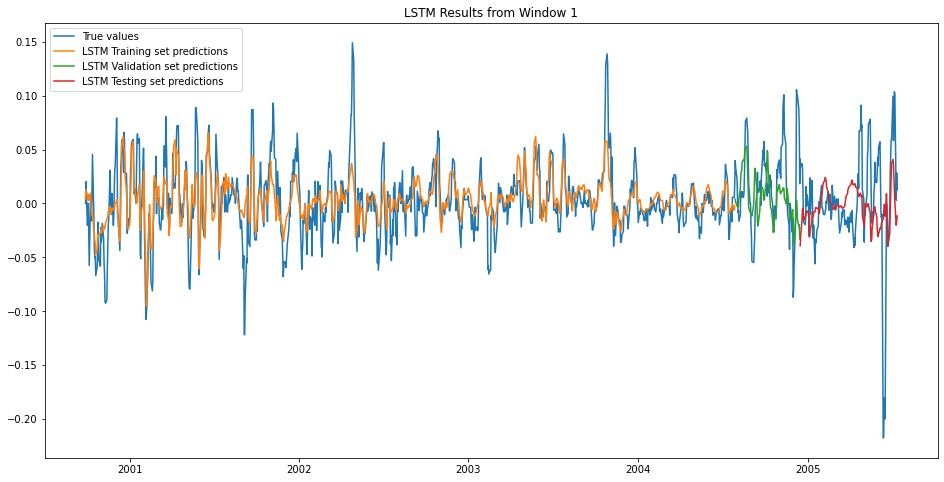

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.000849569128421685
RMSE = 0.029147369150948853
MAE = 0.02054038886714915
R-Squared = 0.07567067654741588

Results on Validation set: 
MSE = 0.003045100342007871
RMSE = 0.05518242783720077
MAE = 0.03566988424686494
R-Squared = 0.08746795987405298

Results on Testing set: 
MSE = 0.0009296204558315483
RMSE = 0.030489677857129752
MAE = 0.023784831133128848
R-Squared = -0.06598127812406873



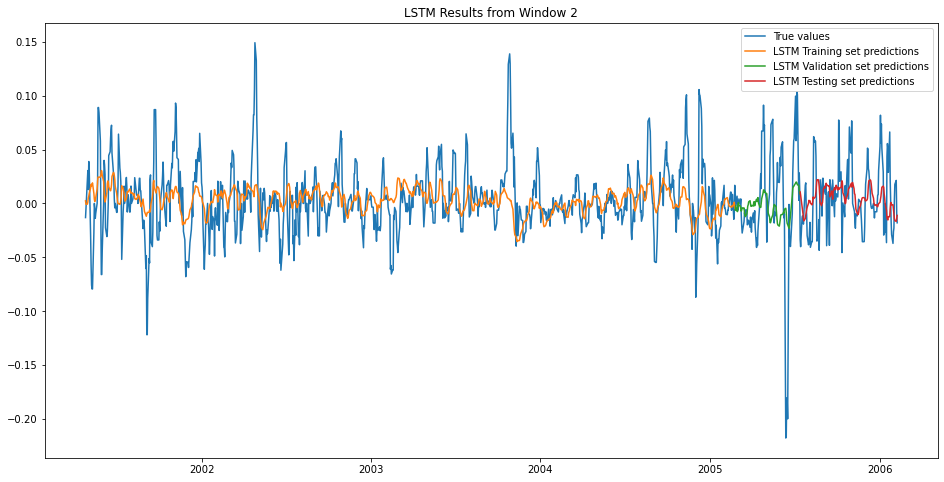

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0008688111672870969
RMSE = 0.02947560291643068
MAE = 0.01891306615236321
R-Squared = 0.18220313081078587

Results on Validation set: 
MSE = 0.0008302663665123857
RMSE = 0.028814343069249137
MAE = 0.02148951897294018
R-Squared = 0.06205336550618856

Results on Testing set: 
MSE = 0.001096663606804761
RMSE = 0.03311591168614811
MAE = 0.02610295542915658
R-Squared = 0.02067198208944898



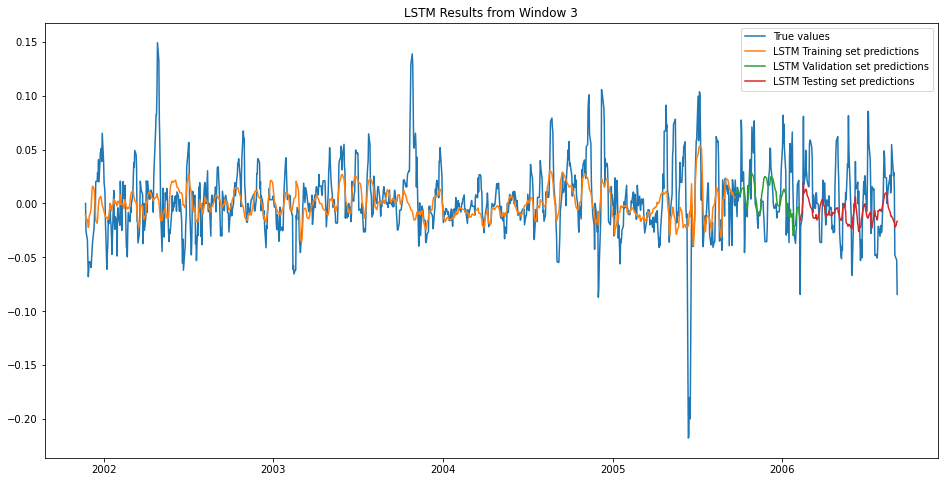

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0009575179397857246
RMSE = 0.030943786771914724
MAE = 0.020116149145898782
R-Squared = 0.051302049025839125

Results on Validation set: 
MSE = 0.0011557584239414852
RMSE = 0.033996447225283485
MAE = 0.02805312614519161
R-Squared = 0.08606538733816416

Results on Testing set: 
MSE = 0.0008240584978401391
RMSE = 0.02870641910514335
MAE = 0.02277851333943576
R-Squared = 0.07564162851116052



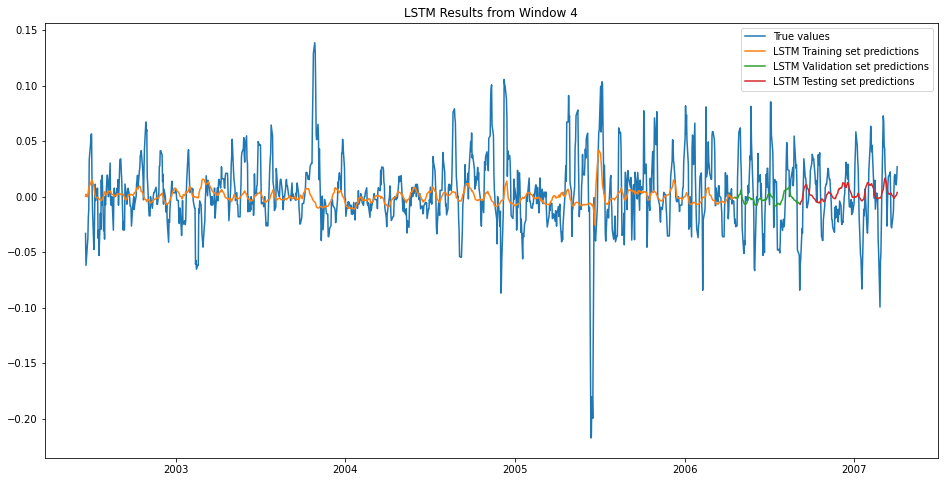

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0010575420646716496
RMSE = 0.032519871842792515
MAE = 0.021939598462543532
R-Squared = 0.02691621386497489

Results on Validation set: 
MSE = 0.0009501454824234891
RMSE = 0.030824429961046954
MAE = 0.023664611192932852
R-Squared = 0.04840078996151698

Results on Testing set: 
MSE = 0.0009752963219171416
RMSE = 0.031229734579678092
MAE = 0.02408009460420877
R-Squared = 0.009272809515502134



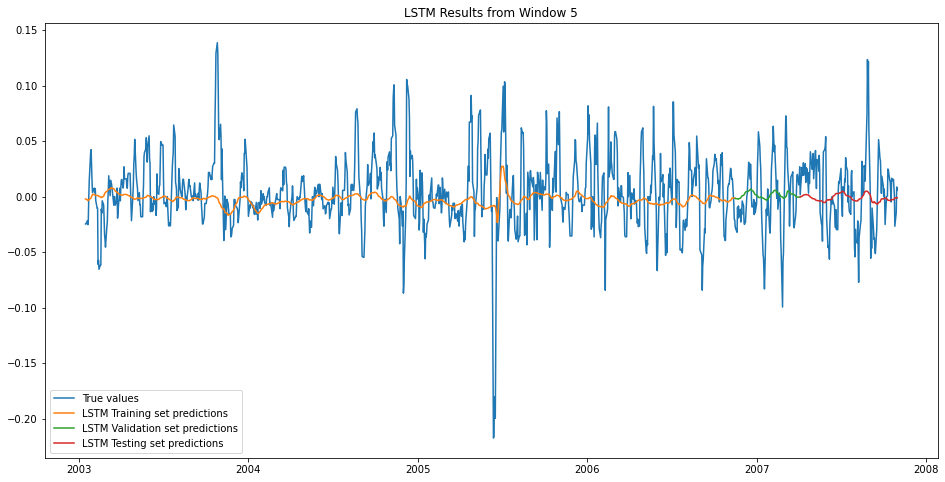

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.001043611172672902
RMSE = 0.03230497133063118
MAE = 0.022048607365022108
R-Squared = 0.08420888889314404

Results on Validation set: 
MSE = 0.0009970627858636525
RMSE = 0.031576301016168005
MAE = 0.02295522187990167
R-Squared = 0.07760428573057443

Results on Testing set: 
MSE = 0.0018606953342381598
RMSE = 0.04313577789072732
MAE = 0.03324386088574452
R-Squared = -0.4263027064429854



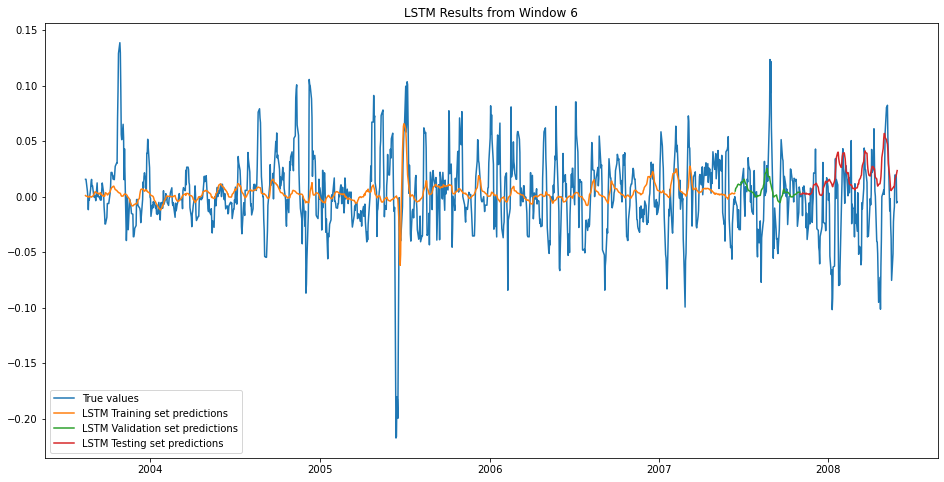

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0010970248202108708
RMSE = 0.03312136501128646
MAE = 0.023571667410325802
R-Squared = 0.07111250747653497

Results on Validation set: 
MSE = 0.0018054986708477755
RMSE = 0.04249115991412538
MAE = 0.033132356259583565
R-Squared = -0.150732663589622

Results on Testing set: 
MSE = 0.0025547988924491446
RMSE = 0.05054501847313091
MAE = 0.03839941778678991
R-Squared = -0.07027363875091308



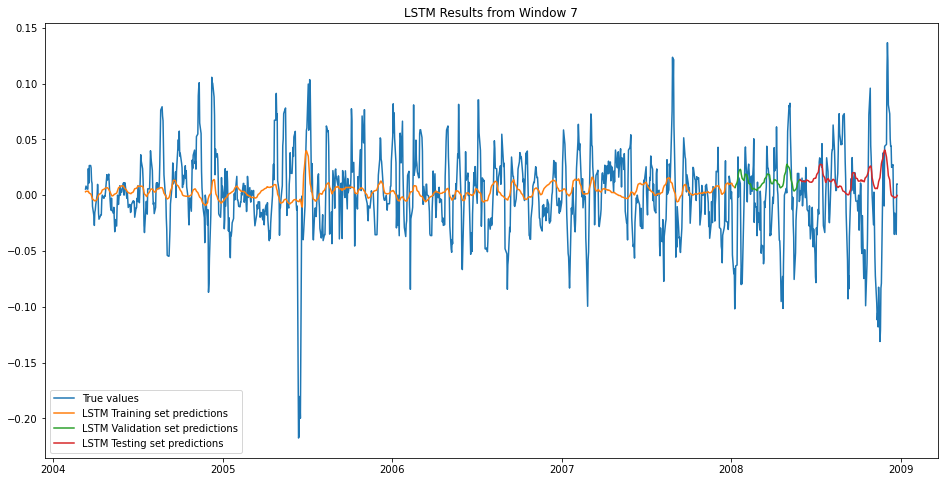

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0012800590191297556
RMSE = 0.0357779124479022
MAE = 0.025952987404352777
R-Squared = 0.02372370439402871

Results on Validation set: 
MSE = 0.002621852737186397
RMSE = 0.05120403047794575
MAE = 0.041439378777882056
R-Squared = 0.1758228883445495

Results on Testing set: 
MSE = 0.0039974598257835016
RMSE = 0.0632254681736996
MAE = 0.04302728207055573
R-Squared = -0.8639626983489144



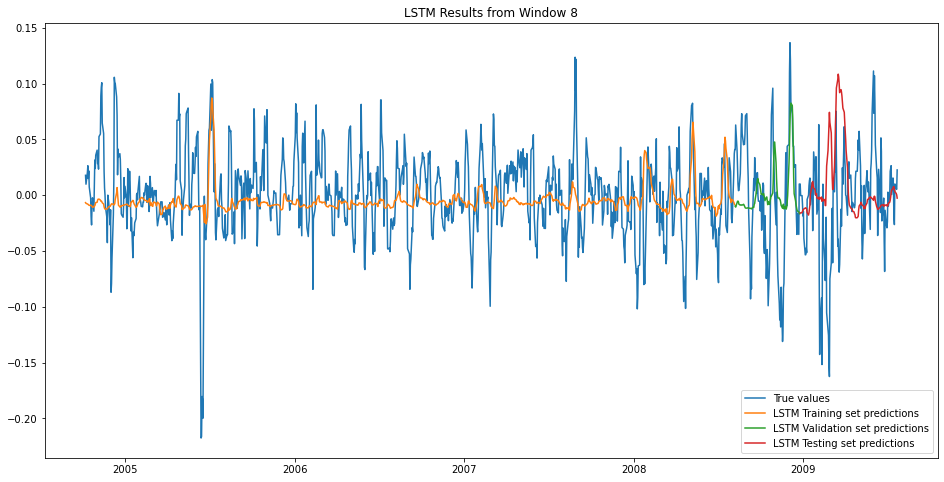

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0015922293449240521
RMSE = 0.03990274858858788
MAE = 0.028753985840832233
R-Squared = 0.03856187374194342

Results on Validation set: 
MSE = 0.0012579493312648792
RMSE = 0.03546758141267711
MAE = 0.026467315020894167
R-Squared = -0.057397412248742175

Results on Testing set: 
MSE = 0.0011003816713870994
RMSE = 0.03317200131718163
MAE = 0.02692039393074649
R-Squared = 0.003555359608356845



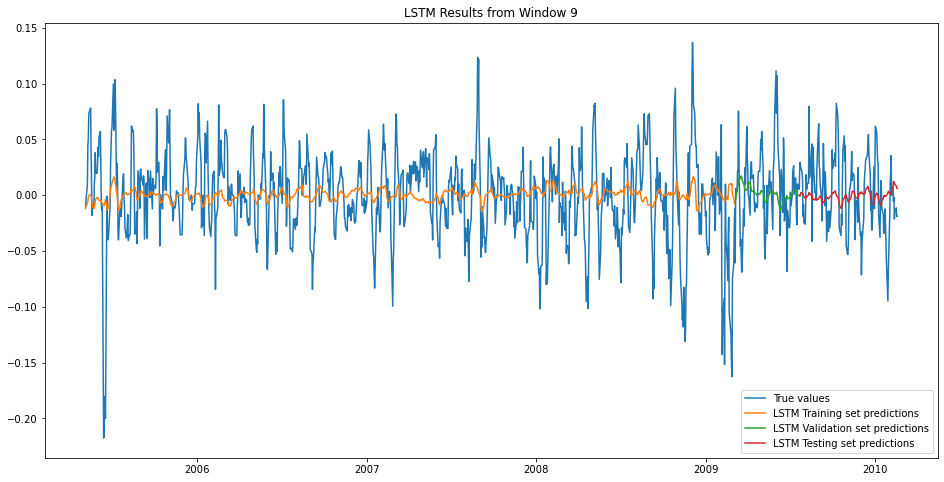

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.0011054688154399828
RMSE = 0.03324859117977757
MAE = 0.02510775104278786
R-Squared = 0.23571604277350755

Results on Validation set: 
MSE = 0.0012353367676577979
RMSE = 0.03514735790436883
MAE = 0.0287110559708763
R-Squared = 0.0350371898537587

Results on Testing set: 
MSE = 0.0007920778366943193
RMSE = 0.028143877428213747
MAE = 0.022301894627229455
R-Squared = -0.009741808343145308



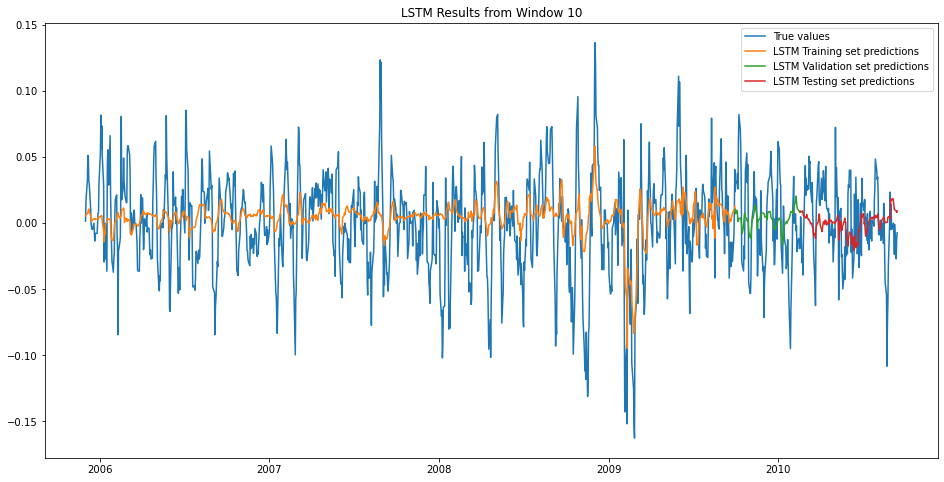

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0013596357615785549
RMSE = 0.03687323909800378
MAE = 0.028022845729668632
R-Squared = 0.06730661033482066

Results on Validation set: 
MSE = 0.0007510492615998977
RMSE = 0.02740527798800621
MAE = 0.02072018179286881
R-Squared = 0.022209543299768875

Results on Testing set: 
MSE = 0.0007041299056163805
RMSE = 0.026535446210990694
MAE = 0.019238073821909812
R-Squared = -0.08136408045057841



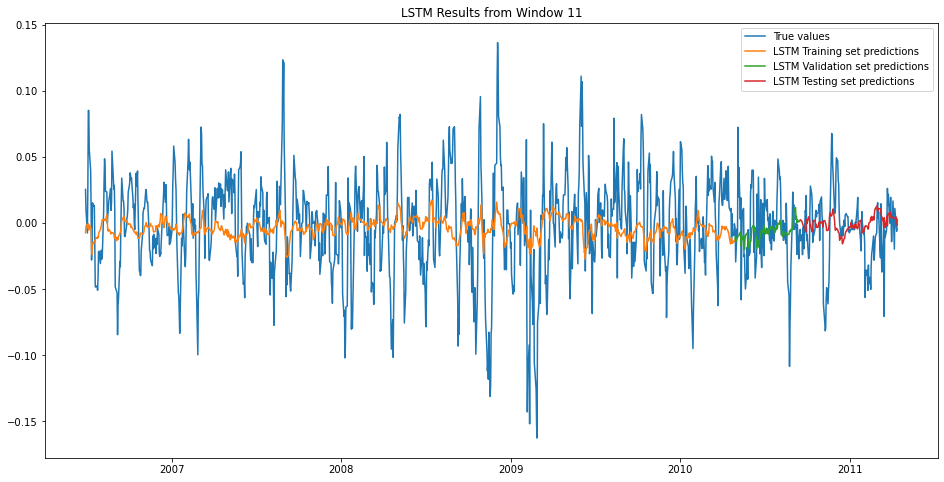

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.001450719061169667
RMSE = 0.03808830609478015
MAE = 0.028981242503271568
R-Squared = -0.0035898882548563993

Results on Validation set: 
MSE = 0.0004614654901787154
RMSE = 0.021481747838076756
MAE = 0.015592160818083588
R-Squared = -0.015735917449577475

Results on Testing set: 
MSE = 0.001013135508321502
RMSE = 0.0318297896367774
MAE = 0.023488454185544214
R-Squared = 0.03399470190863085



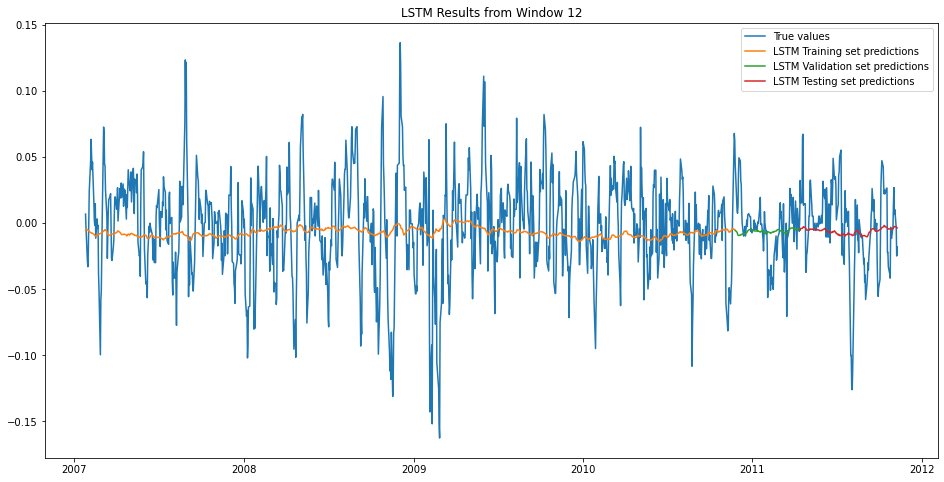

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.0009502860274363676
RMSE = 0.030826709643365566
MAE = 0.022126029941762347
R-Squared = 0.3120165126684443

Results on Validation set: 
MSE = 0.001178923205933385
RMSE = 0.03433545115377669
MAE = 0.024556399484612988
R-Squared = 0.08214784168170075

Results on Testing set: 
MSE = 0.0010762213172871766
RMSE = 0.03280581224855097
MAE = 0.022423553528687704
R-Squared = -0.3410438556500266



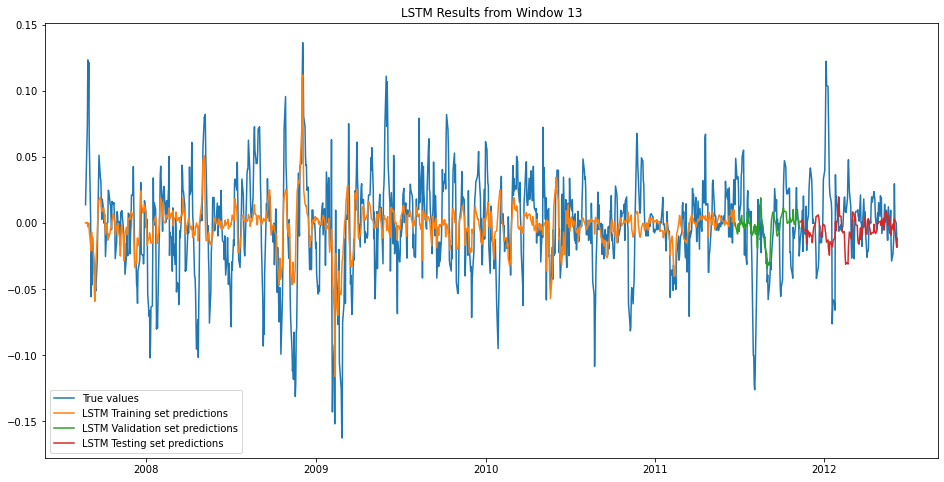

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.0012864368995852407
RMSE = 0.035866933233623985
MAE = 0.02609408790808341
R-Squared = 0.08864127549278977

Results on Validation set: 
MSE = 0.00039461217655767833
RMSE = 0.019864847760747584
MAE = 0.014321634380630468
R-Squared = -0.015105284406683461

Results on Testing set: 
MSE = 0.00048770366385917643
RMSE = 0.02208401376242952
MAE = 0.016189608626813165
R-Squared = -0.1625049072477014



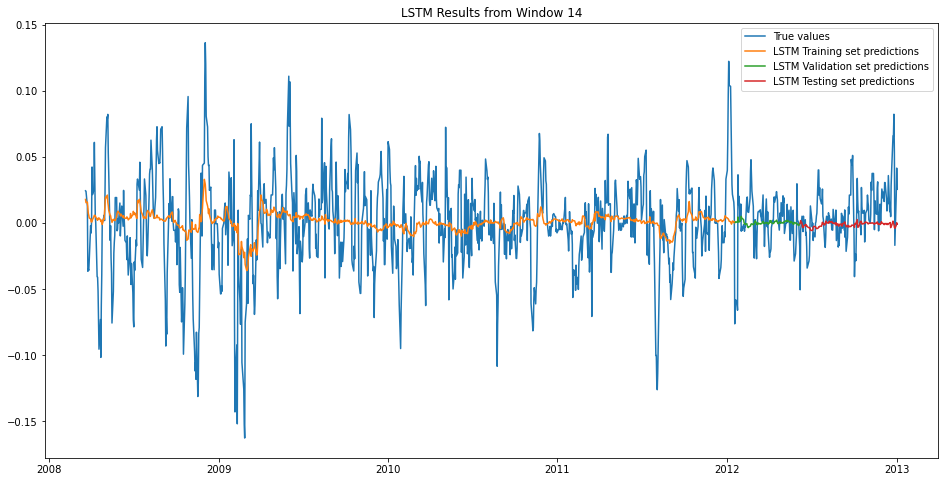

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0010944722571473546
RMSE = 0.03308280908791384
MAE = 0.023573495849710937
R-Squared = 0.11506688311253344

Results on Validation set: 
MSE = 0.0005166086132310975
RMSE = 0.022729025787109697
MAE = 0.016858022853042488
R-Squared = -0.17074882287277227

Results on Testing set: 
MSE = 0.0010277093544609833
RMSE = 0.03205790627069995
MAE = 0.02415491058677304
R-Squared = -0.06992175292468561



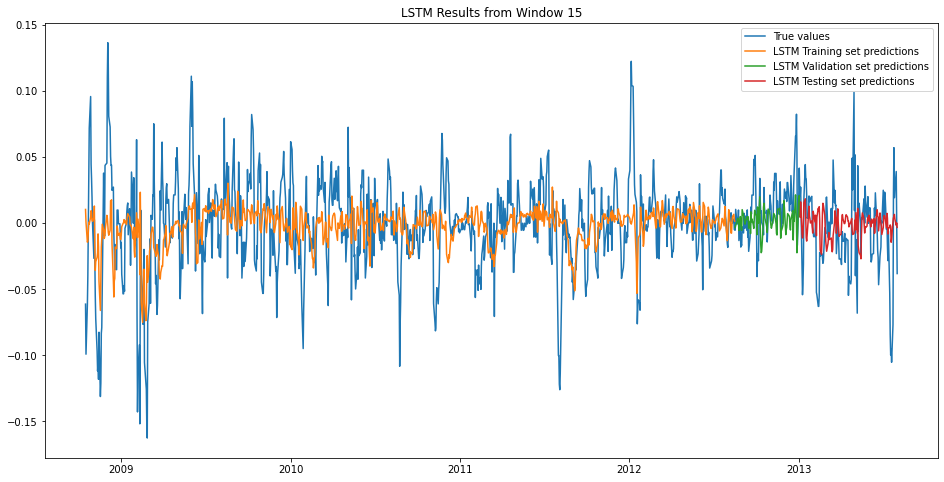

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.0008434553351015556
RMSE = 0.02904230251033061
MAE = 0.021386582306332322
R-Squared = 0.002500325946463544

Results on Validation set: 
MSE = 0.0010857136381437888
RMSE = 0.032950169015405505
MAE = 0.024362686095908283
R-Squared = -0.002513507890103517

Results on Testing set: 
MSE = 0.001694462009183805
RMSE = 0.041163843469528026
MAE = 0.03076651826988421
R-Squared = 0.033425344445546346



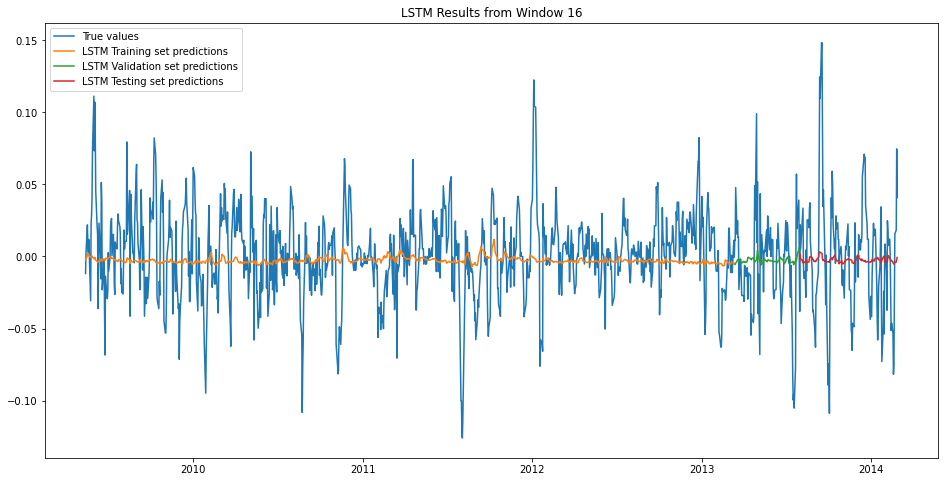

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007009067706369804
RMSE = 0.026474643918983697
MAE = 0.017958172766468525
R-Squared = 0.2541003870436548

Results on Validation set: 
MSE = 0.0008866062714506192
RMSE = 0.02977593443454998
MAE = 0.02185952081866809
R-Squared = 0.19637373025011595

Results on Testing set: 
MSE = 0.0006950982607570944
RMSE = 0.0263647162085446
MAE = 0.021075916581351228
R-Squared = -0.027111818583653857



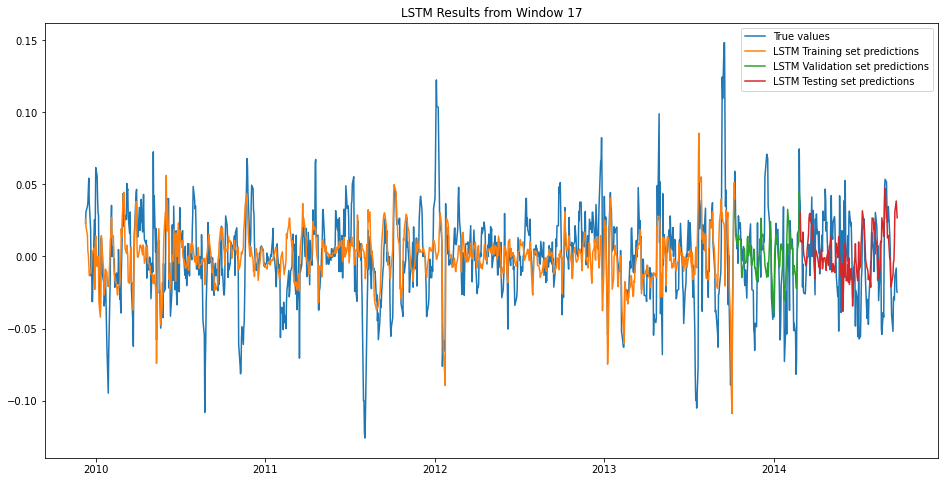

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0005252910929332029
RMSE = 0.02291922976308765
MAE = 0.01478499117058987
R-Squared = 0.43600635911750085

Results on Validation set: 
MSE = 0.0007559194329941406
RMSE = 0.027493989033862305
MAE = 0.021158424890552148
R-Squared = 0.01934341191052158

Results on Testing set: 
MSE = 0.003953072675813969
RMSE = 0.06287346559411187
MAE = 0.05079419683831489
R-Squared = -0.5563156474001636



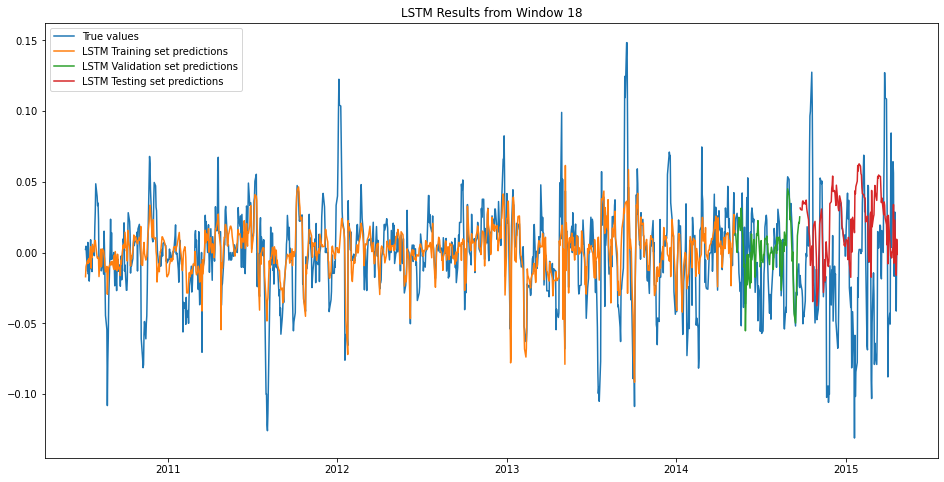

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0010382761989635918
RMSE = 0.032222293508743165
MAE = 0.023206945919263068
R-Squared = 0.0024539720132878973

Results on Validation set: 
MSE = 0.002516293490712794
RMSE = 0.050162670290892546
MAE = 0.03908132645534289
R-Squared = -0.018449616992633366

Results on Testing set: 
MSE = 0.001510512283928113
RMSE = 0.03886530951797648
MAE = 0.026808466972435514
R-Squared = 0.007981764003819558



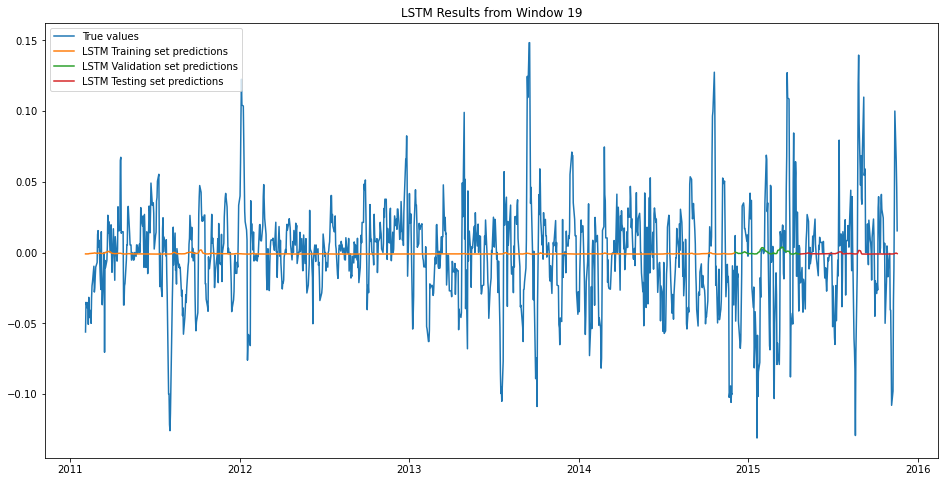

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.001104975020601863
RMSE = 0.0332411645494237
MAE = 0.023782725662790785
R-Squared = 0.04354236299637626

Results on Validation set: 
MSE = 0.002224447589511654
RMSE = 0.04716404975732739
MAE = 0.03568815364289988
R-Squared = -0.033344216969934726

Results on Testing set: 
MSE = 0.0031313445051428038
RMSE = 0.055958417643307286
MAE = 0.04210630232058179
R-Squared = -0.023061106187299174



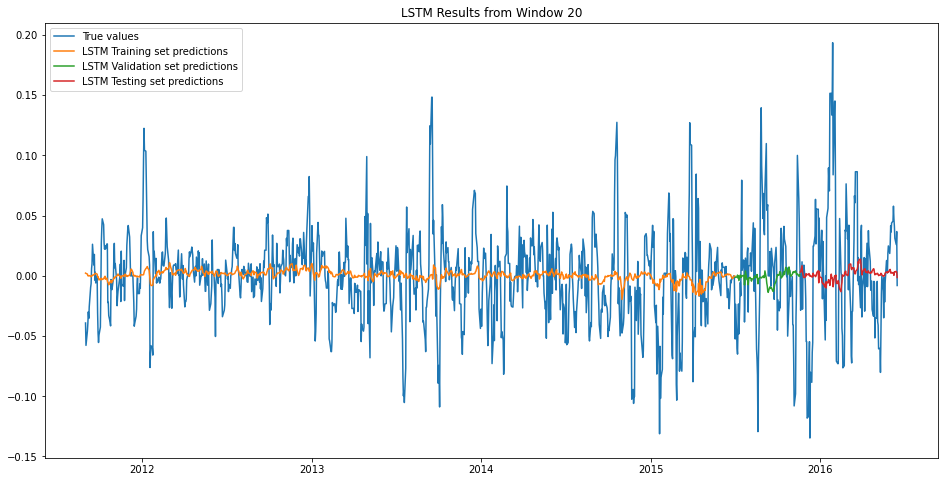

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.001869283493081565
RMSE = 0.04323521126444931
MAE = 0.02889078458009496
R-Squared = -0.29857993060368915

Results on Validation set: 
MSE = 0.0016914019235265334
RMSE = 0.04112665709155722
MAE = 0.030480965856939234
R-Squared = 0.2949701135367674

Results on Testing set: 
MSE = 0.0011650146459862938
RMSE = 0.03413231087966787
MAE = 0.026442531494495825
R-Squared = -0.07404500163615979



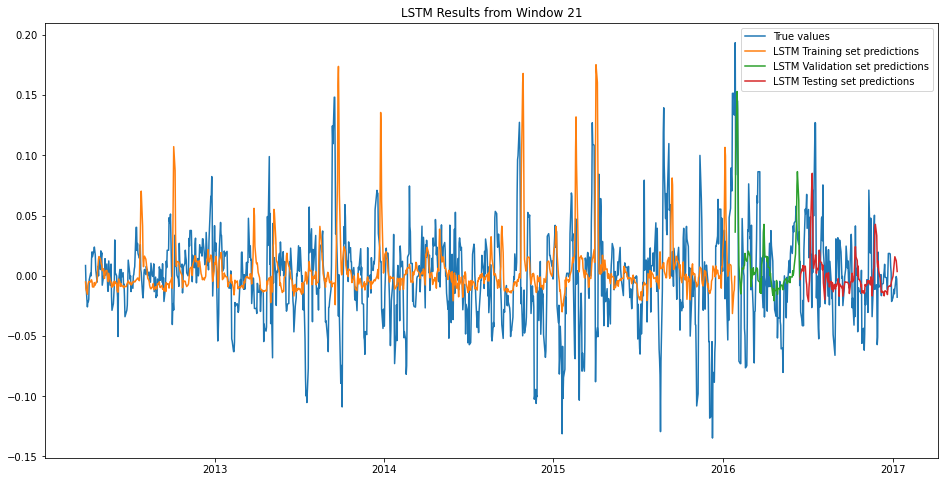

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0008012651248142793
RMSE = 0.028306626871004593
MAE = 0.019201167558437923
R-Squared = 0.5376554577580026

Results on Validation set: 
MSE = 0.0005475605076627519
RMSE = 0.023400010847492183
MAE = 0.018285880900266845
R-Squared = 0.1917049199269616

Results on Testing set: 
MSE = 0.0005695629919023484
RMSE = 0.02386551889028077
MAE = 0.019533800105829918
R-Squared = -0.04343581688728282



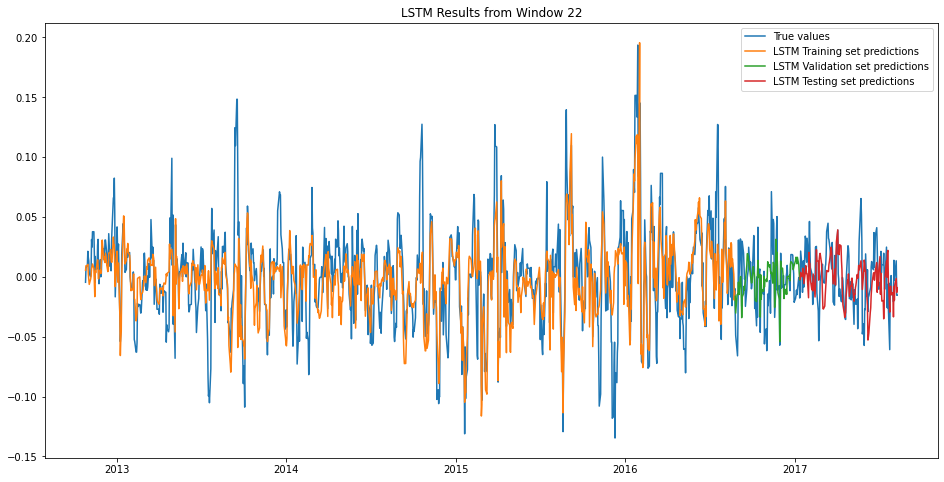

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0014556152561846592
RMSE = 0.03815252620973687
MAE = 0.027650800774702455
R-Squared = 0.1470027090997622

Results on Validation set: 
MSE = 0.000569830962727775
RMSE = 0.023871132414022066
MAE = 0.017851769130893758
R-Squared = -0.0422540470424857

Results on Testing set: 
MSE = 0.0025881389944037137
RMSE = 0.050873755458032716
MAE = 0.03797088086166133
R-Squared = -0.3130299754553507



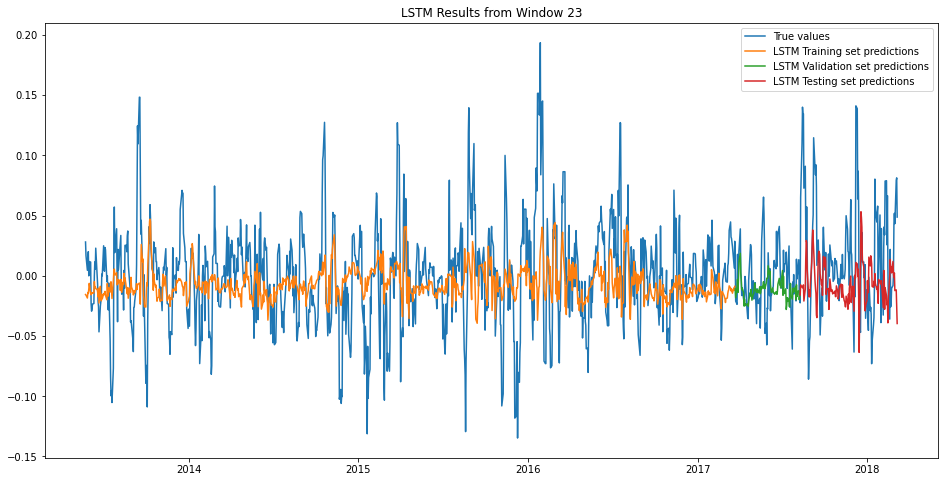

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0004979884460847581
RMSE = 0.02231565473125891
MAE = 0.014988400050108843
R-Squared = 0.7019515795633439

Results on Validation set: 
MSE = 0.001484812859973507
RMSE = 0.03853326952094134
MAE = 0.028962462138103003
R-Squared = 0.022975085189961497

Results on Testing set: 
MSE = 0.0016268852422422235
RMSE = 0.040334665515437504
MAE = 0.03275991537172695
R-Squared = -0.21133712829796036



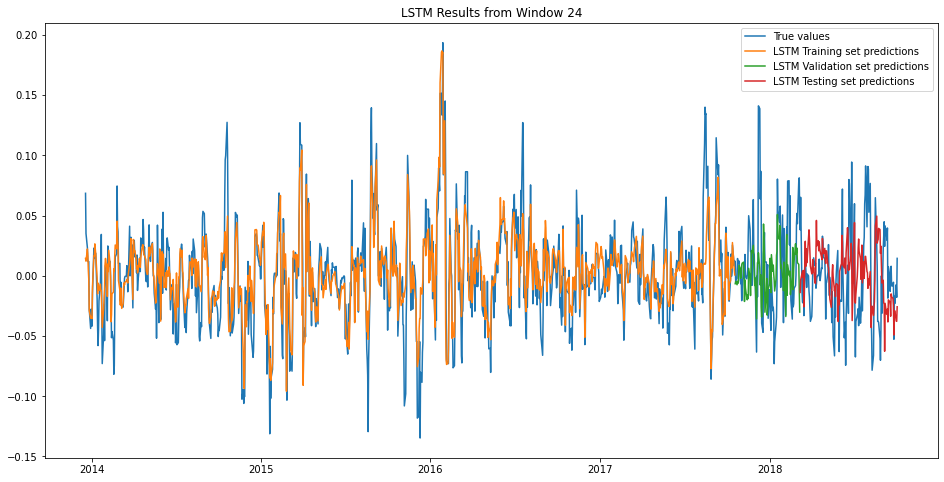

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0014032450851546605
RMSE = 0.037459913042540025
MAE = 0.026425956646239313
R-Squared = 0.186001189300406

Results on Validation set: 
MSE = 0.0015946911003667248
RMSE = 0.03993358361538224
MAE = 0.032114822634956165
R-Squared = 0.12098899043820577

Results on Testing set: 
MSE = 0.0013390415402582886
RMSE = 0.036592916531185224
MAE = 0.02910515707792308
R-Squared = -0.2860924229228694



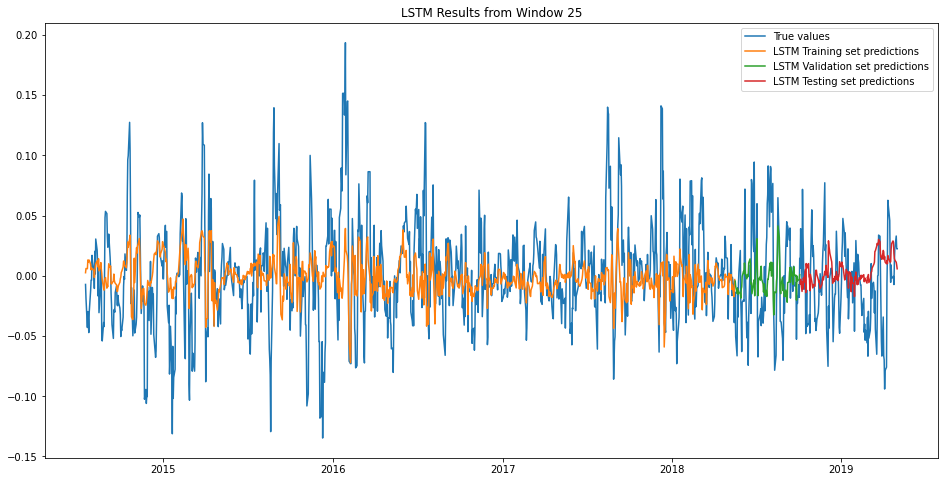

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 5018

Results on Training set: 
MSE = 0.0014811457170307595
RMSE = 0.03848565599065137
MAE = 0.027678074398848403
R-Squared = 0.11110038411756562

Results on Validation set: 
MSE = 0.0012077427698759344
RMSE = 0.03475259371436806
MAE = 0.027640007191220048
R-Squared = -0.1686811896514877

Results on Testing set: 
MSE = 0.0008119173056052265
RMSE = 0.028494162658432805
MAE = 0.022051294836417587
R-Squared = -0.07069997039834663



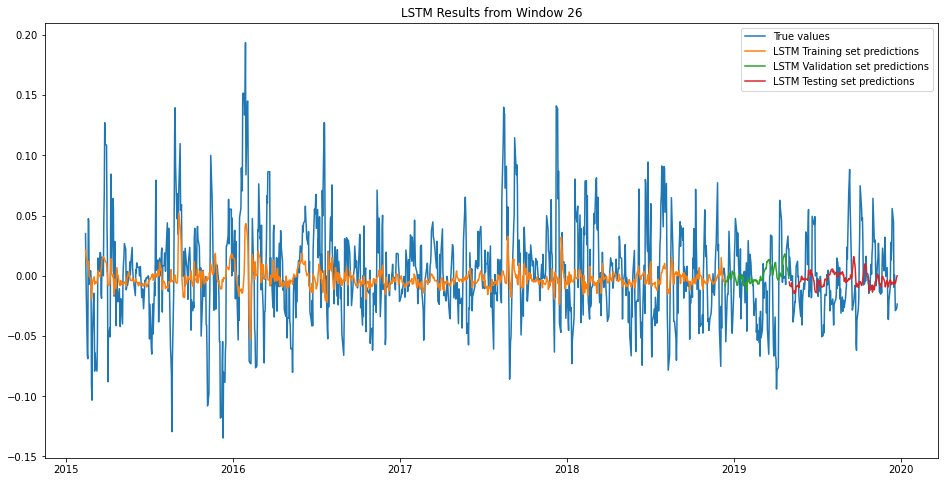

In [7]:
dataset = df.values
totaldatapoints = len(dataset)

#Declaring model parameters
sequencelength = 100
features = len(df.columns) - 1
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
lstm_predictions = np.zeros((numPredictions + extra,1)) 
lstm_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test LSTM
  lstm_model = create_lstm()
  lstm_history, lstm_model = train_lstm(lstm_model, x_train, y_train, x_val, y_val)
  lstm_predictions, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions = makePredictions(lstm_model, lstm_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, lstm_trainingPredictions, lstm_valPredictions, lstm_testingPredictions)

  lstm_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['LSTM Train Predictions'] = lstm_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['LSTM Val Predictions'] = lstm_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['LSTM Test Predictions'] = lstm_testingPredictions

  #Plot LSTM Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['LSTM Train Predictions'], label = 'LSTM Training set predictions')
  plt.plot(valGraph['LSTM Val Predictions'], label = 'LSTM Validation set predictions')
  plt.plot(testGraph['LSTM Test Predictions'], label = 'LSTM Testing set predictions')
  plt.title("LSTM Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

In [8]:
K.clear_session()
tf.compat.v1.reset_default_graph()

**GRU model**

In [9]:
def create_gru():
  '''
  Function to create an GRU using the Keras Framework
  @returns
    model - Compiled GRU
  '''
  #hyperparameters
  learningRate = 0.008043191210903316
  dropout = 0.22844898929603968
  units = 42

  #Construct GRU
  model = Sequential()
  model.add(GRU(units=units, return_sequences=True, input_shape=(sequencelength, features)))
  model.add(GRU(units=units, dropout=dropout))
  model.add(Dense(1))

  #GRU compile
  ao = Adam(lr=learningRate, amsgrad=True)
  model.compile(loss='mae', optimizer=ao, metrics=['mse','mae', 'mape', 'msle'])

  return model

def train_gru(model, x_train, y_train, x_val, y_val):
  '''
  Function to train the LSTM
  @params:
    model - Keras LSTM model
    x_train - Training Input
    y_train - Training Output
    x_val - Validation Input
    y_val - Validation Output
  @returns:
    history - Model history
    model - Best model according to early stopping
  '''
  batchSize = 68
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=20)
  mc = ModelCheckpoint('./GRU.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
  history = model.fit(x_train, y_train, epochs=150, batch_size=batchSize, verbose=0, validation_data = (x_val, y_val), callbacks=[es, mc])
  model = load_model('./GRU.h5')
  return history, model

**GRU Forecasting Implementation**

Window 1: 
Training datapoints: 0 - 999
Validation datapoints: 1000 - 1099
Testing datapoints: 1100 - 1249

Results on Training set: 
MSE = 0.0007305120351477566
RMSE = 0.027027986146728664
MAE = 0.018649073959811004
R-Squared = 0.2590928072066294

Results on Validation set: 
MSE = 0.0016233350236561433
RMSE = 0.04029063195900684
MAE = 0.029373278289911823
R-Squared = -0.06982939428765711

Results on Testing set: 
MSE = 0.0024095100579778006
RMSE = 0.04908676051623086
MAE = 0.031857072871965375
R-Squared = -0.024441599409534165



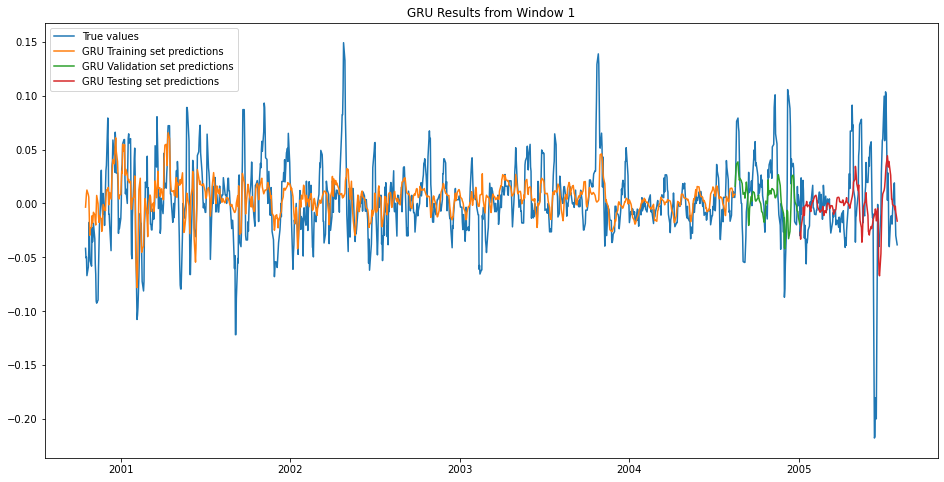

Window 2: 
Training datapoints: 150 - 1149
Validation datapoints: 1150 - 1249
Testing datapoints: 1250 - 1399

Results on Training set: 
MSE = 0.0007299030482096496
RMSE = 0.027016717939262157
MAE = 0.01821765012218034
R-Squared = 0.18194546512152354

Results on Validation set: 
MSE = 0.003037657172757372
RMSE = 0.05511494509438771
MAE = 0.03523470774339585
R-Squared = 0.10280262907518367

Results on Testing set: 
MSE = 0.0008434290471399571
RMSE = 0.029041849926269455
MAE = 0.022806161378503446
R-Squared = 0.09865916646629258



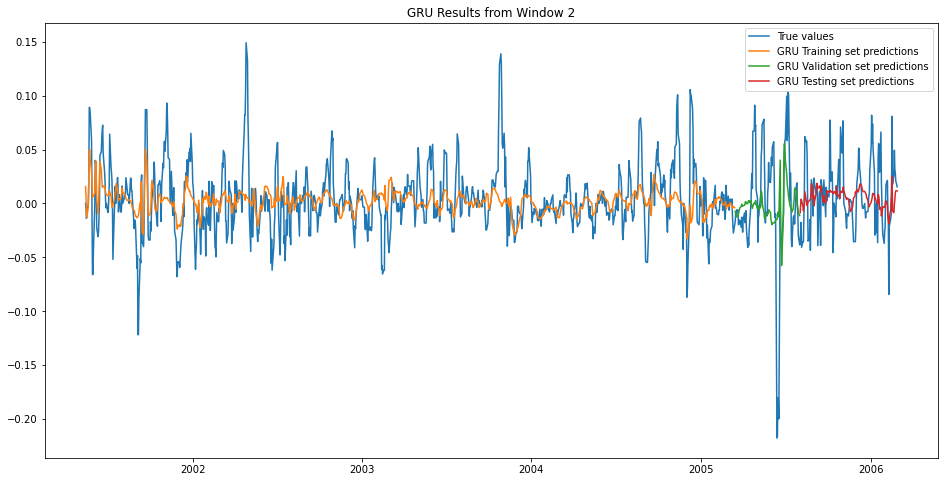

Window 3: 
Training datapoints: 300 - 1299
Validation datapoints: 1300 - 1399
Testing datapoints: 1400 - 1549

Results on Training set: 
MSE = 0.0009266812182092143
RMSE = 0.030441439161268548
MAE = 0.019193956529750512
R-Squared = 0.11026245874593554

Results on Validation set: 
MSE = 0.0008472521593893087
RMSE = 0.02910759624890569
MAE = 0.021916878174437004
R-Squared = 0.1369537540376753

Results on Testing set: 
MSE = 0.0011284491864952527
RMSE = 0.03359239774852716
MAE = 0.026599113437528247
R-Squared = -0.06171033231401335



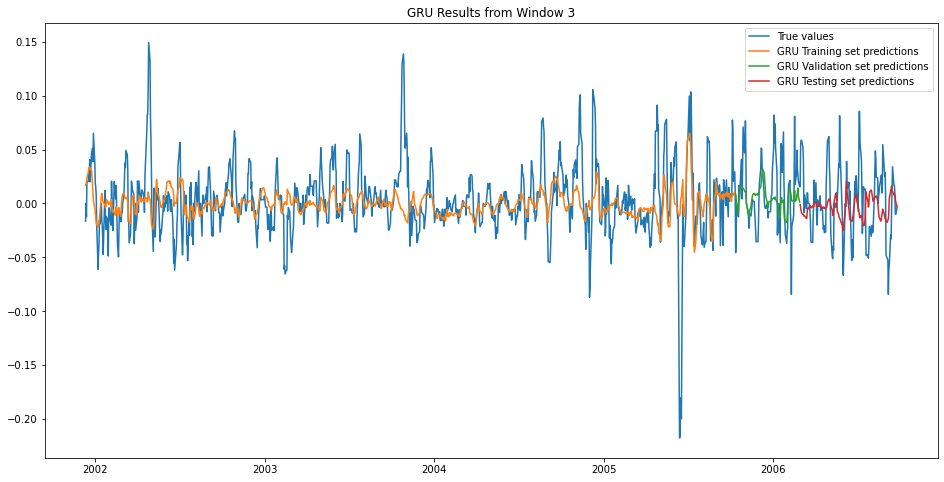

Window 4: 
Training datapoints: 450 - 1449
Validation datapoints: 1450 - 1549
Testing datapoints: 1550 - 1699

Results on Training set: 
MSE = 0.0008407884140543166
RMSE = 0.028996351736974027
MAE = 0.0191155642726209
R-Squared = 0.162774749053901

Results on Validation set: 
MSE = 0.0010738744162883714
RMSE = 0.03277002313530419
MAE = 0.026565318674338603
R-Squared = 0.10741017117315055

Results on Testing set: 
MSE = 0.000835903156756788
RMSE = 0.028911989844297954
MAE = 0.023190347713602302
R-Squared = 0.012147240244454793



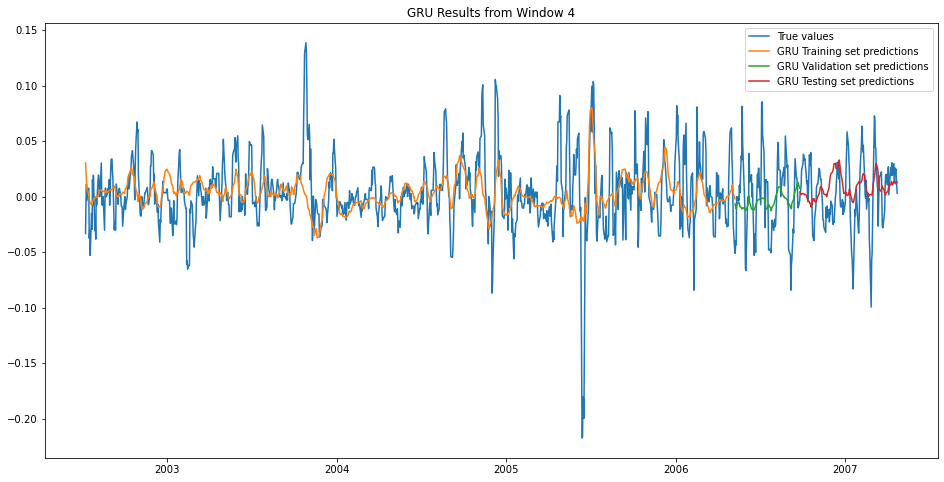

Window 5: 
Training datapoints: 600 - 1599
Validation datapoints: 1600 - 1699
Testing datapoints: 1700 - 1849

Results on Training set: 
MSE = 0.0007443818092276135
RMSE = 0.027283361398984796
MAE = 0.017939605509856096
R-Squared = 0.3145849590262292

Results on Validation set: 
MSE = 0.0008603337622361294
RMSE = 0.029331446644107573
MAE = 0.022309701936823686
R-Squared = 0.14263583314947947

Results on Testing set: 
MSE = 0.0014722511368869162
RMSE = 0.038369924900720304
MAE = 0.029531640780464108
R-Squared = -0.48717366001953044



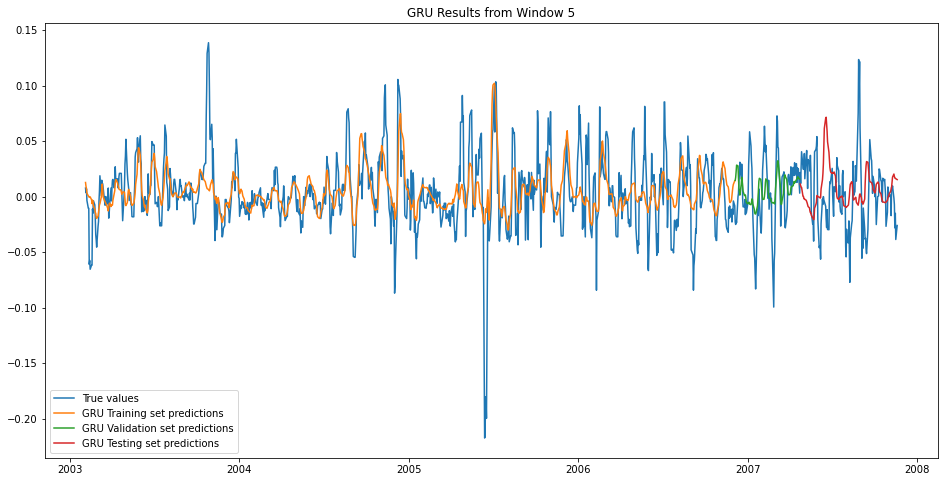

Window 6: 
Training datapoints: 750 - 1749
Validation datapoints: 1750 - 1849
Testing datapoints: 1850 - 1999

Results on Training set: 
MSE = 0.0011003561784849625
RMSE = 0.03317161706165321
MAE = 0.02306465494440043
R-Squared = 0.037952751722201805

Results on Validation set: 
MSE = 0.0009098238806088878
RMSE = 0.030163286966258963
MAE = 0.022188734896082273
R-Squared = 0.15380936820713342

Results on Testing set: 
MSE = 0.0019695531732264533
RMSE = 0.044379648187276716
MAE = 0.03472462122640088
R-Squared = -0.5055751294019677



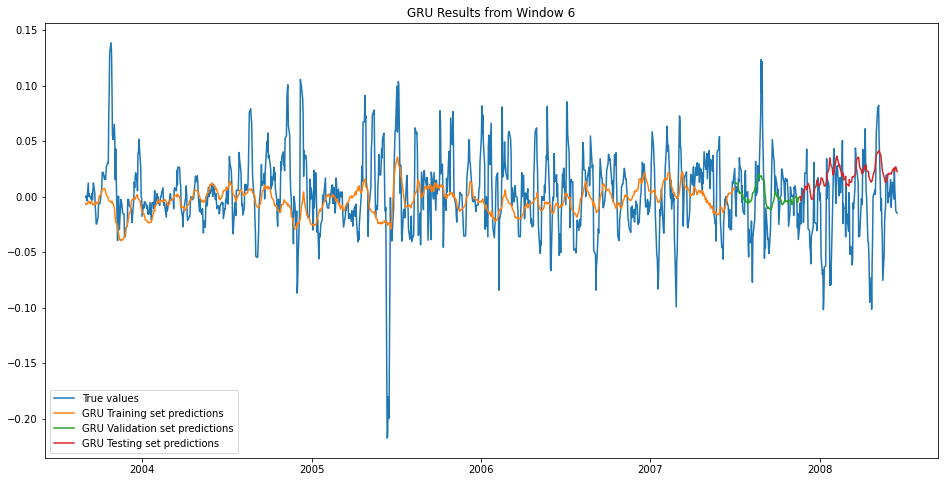

Window 7: 
Training datapoints: 900 - 1899
Validation datapoints: 1900 - 1999
Testing datapoints: 2000 - 2149

Results on Training set: 
MSE = 0.0011265741514580587
RMSE = 0.03356447752398447
MAE = 0.023903628683524067
R-Squared = 0.07444435843907427

Results on Validation set: 
MSE = 0.001042648335344521
RMSE = 0.03229006558284639
MAE = 0.024569962437548325
R-Squared = 0.17761703674257823

Results on Testing set: 
MSE = 0.0027705457182346472
RMSE = 0.052635973613439004
MAE = 0.04174375288838785
R-Squared = -0.13203202462935892



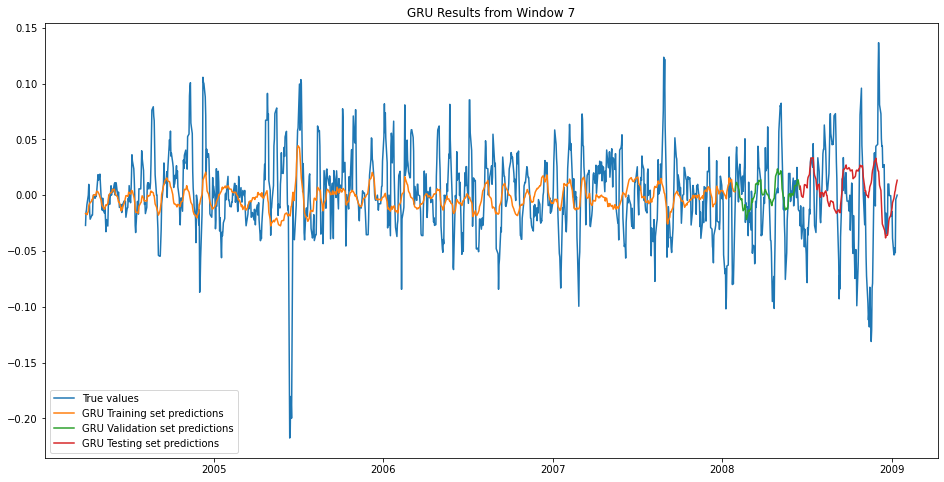

Window 8: 
Training datapoints: 1050 - 2049
Validation datapoints: 2050 - 2149
Testing datapoints: 2150 - 2299

Results on Training set: 
MSE = 0.0012090613503826643
RMSE = 0.03477155950461044
MAE = 0.024925316628820453
R-Squared = 0.09142405499045558

Results on Validation set: 
MSE = 0.0030106905995161766
RMSE = 0.05486976033769581
MAE = 0.042119762568133066
R-Squared = -0.003935806936376851

Results on Testing set: 
MSE = 0.0028739562849088357
RMSE = 0.05360929289693006
MAE = 0.03713425920880405
R-Squared = -0.35623551683548293



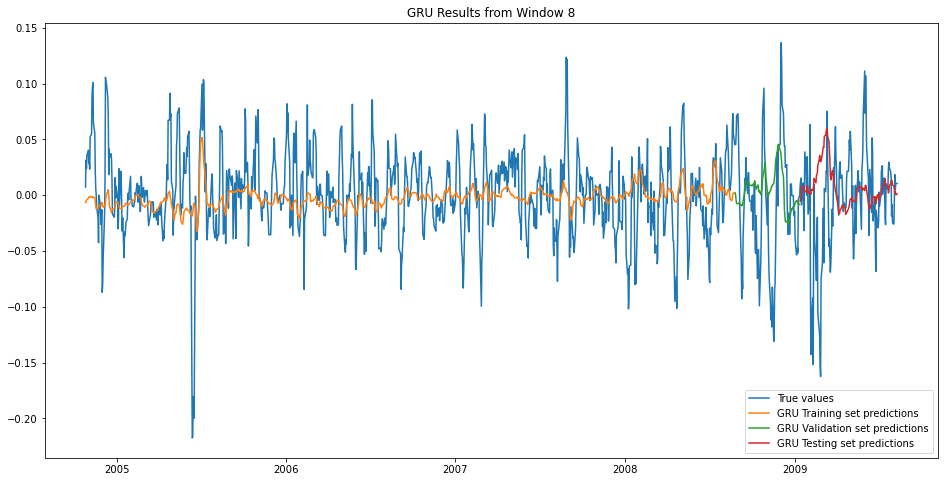

Window 9: 
Training datapoints: 1200 - 2199
Validation datapoints: 2200 - 2299
Testing datapoints: 2300 - 2449

Results on Training set: 
MSE = 0.0018131129380339944
RMSE = 0.04258066389846446
MAE = 0.031030588136513045
R-Squared = -0.0938707932878855

Results on Validation set: 
MSE = 0.0009453818679549184
RMSE = 0.030747062753292684
MAE = 0.02295979950352173
R-Squared = -0.019366358138843465

Results on Testing set: 
MSE = 0.0012255295383523013
RMSE = 0.035007564016256563
MAE = 0.026941443274140203
R-Squared = -0.07898861627432918



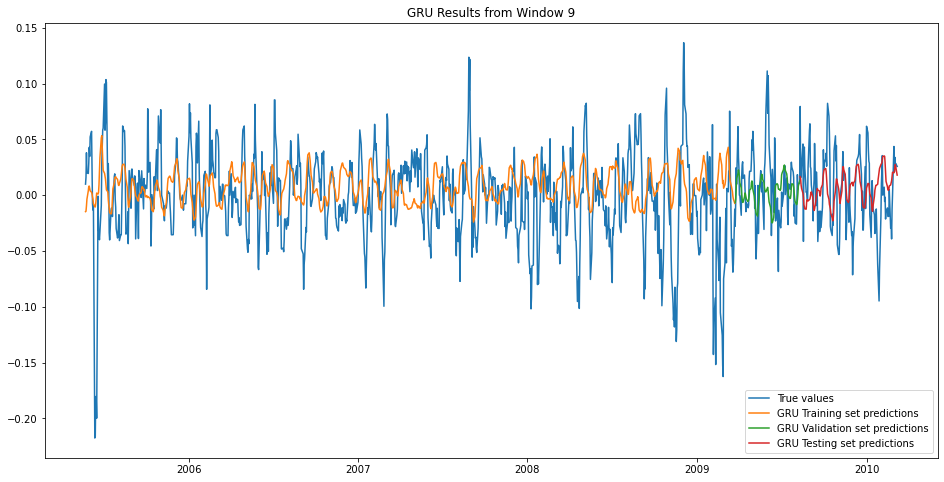

Window 10: 
Training datapoints: 1350 - 2349
Validation datapoints: 2350 - 2449
Testing datapoints: 2450 - 2599

Results on Training set: 
MSE = 0.001478411662298698
RMSE = 0.03845011914544216
MAE = 0.028643586929225882
R-Squared = -0.00869206760271668

Results on Validation set: 
MSE = 0.0011090753002304743
RMSE = 0.033302782169519624
MAE = 0.026755568927885595
R-Squared = -0.020868188058850157

Results on Testing set: 
MSE = 0.0007900584295484374
RMSE = 0.02810797804091282
MAE = 0.02225398562959274
R-Squared = -0.06547929203318015



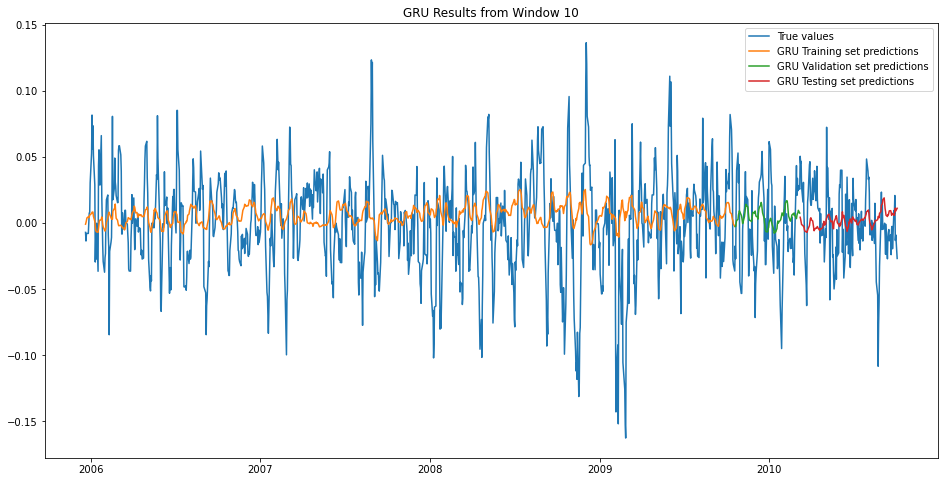

Window 11: 
Training datapoints: 1500 - 2499
Validation datapoints: 2500 - 2599
Testing datapoints: 2600 - 2749

Results on Training set: 
MSE = 0.0014706542348065608
RMSE = 0.038349109961074206
MAE = 0.029356963262454593
R-Squared = -0.016095821021981482

Results on Validation set: 
MSE = 0.0006548348101069806
RMSE = 0.025589740329026018
MAE = 0.019238290559220217
R-Squared = -0.0019035511303493458

Results on Testing set: 
MSE = 0.0007877885892978274
RMSE = 0.028067571845420247
MAE = 0.021330977374226987
R-Squared = -0.05967287330418647



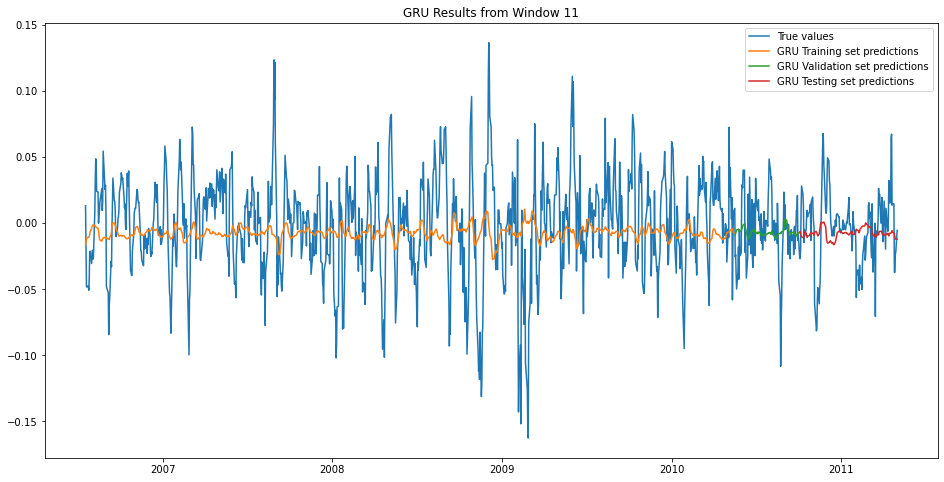

Window 12: 
Training datapoints: 1650 - 2649
Validation datapoints: 2650 - 2749
Testing datapoints: 2750 - 2899

Results on Training set: 
MSE = 0.0014339061492669835
RMSE = 0.03786695326095015
MAE = 0.02866941971189223
R-Squared = 0.005320832909800011

Results on Validation set: 
MSE = 0.0004958397609373019
RMSE = 0.022267459687564314
MAE = 0.016132704874854485
R-Squared = -0.06546402666377626

Results on Testing set: 
MSE = 0.000955967637984364
RMSE = 0.030918726331858562
MAE = 0.022393348767069745
R-Squared = 0.001867337698307714



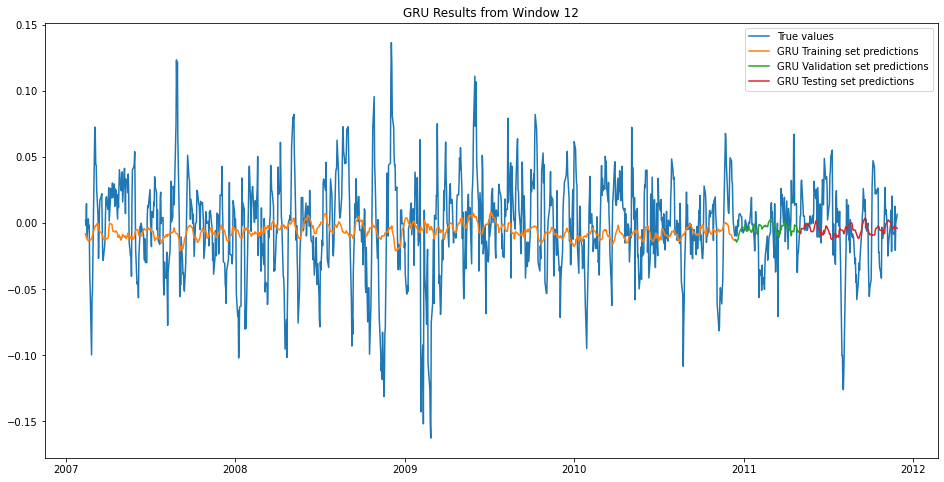

Window 13: 
Training datapoints: 1800 - 2799
Validation datapoints: 2800 - 2899
Testing datapoints: 2900 - 3049

Results on Training set: 
MSE = 0.001292633356029218
RMSE = 0.035953210649804536
MAE = 0.026586720619376378
R-Squared = 0.03655552124683781

Results on Validation set: 
MSE = 0.0009185829659802885
RMSE = 0.03030813366045967
MAE = 0.02072548409509416
R-Squared = 0.12334654951129242

Results on Testing set: 
MSE = 0.0011141425844980793
RMSE = 0.033378774460697015
MAE = 0.023032339116624084
R-Squared = -0.34234626698580306



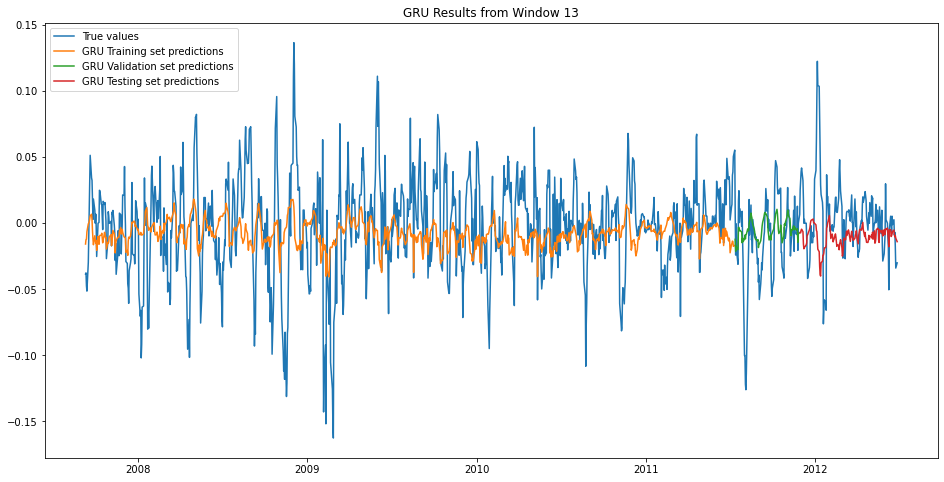

Window 14: 
Training datapoints: 1950 - 2949
Validation datapoints: 2950 - 3049
Testing datapoints: 3050 - 3199

Results on Training set: 
MSE = 0.001336567108759568
RMSE = 0.036559090644593006
MAE = 0.02643255821304121
R-Squared = 0.05851447089649564

Results on Validation set: 
MSE = 0.00028344066440621964
RMSE = 0.016835696136668053
MAE = 0.01289927358065572
R-Squared = -0.07944754599107395

Results on Testing set: 
MSE = 0.000546213615531033
RMSE = 0.023371213394495223
MAE = 0.017762134875770733
R-Squared = -0.20122893817794218



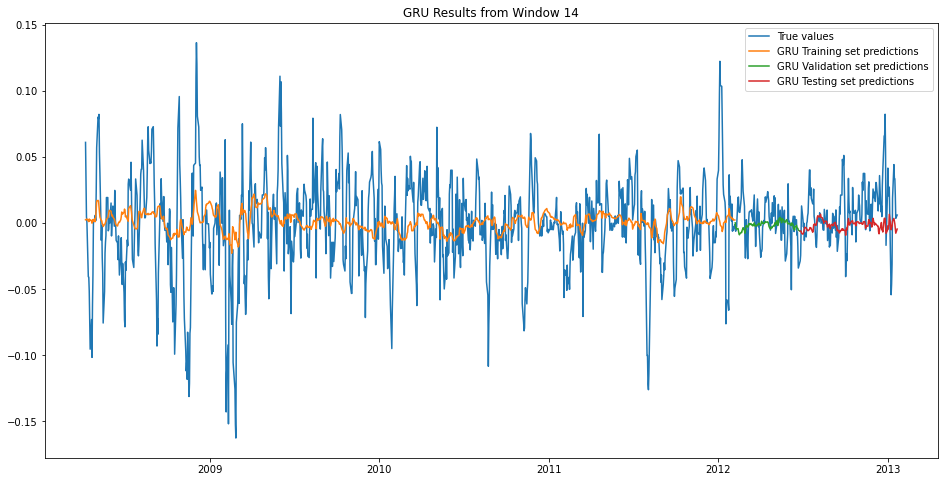

Window 15: 
Training datapoints: 2100 - 3099
Validation datapoints: 3100 - 3199
Testing datapoints: 3200 - 3349

Results on Training set: 
MSE = 0.0011963055392597832
RMSE = 0.03458765009739435
MAE = 0.02466928671702783
R-Squared = 0.0022172217203471067

Results on Validation set: 
MSE = 0.0005863960037394111
RMSE = 0.02421561487427918
MAE = 0.01823807722823183
R-Squared = -0.08854623435967168

Results on Testing set: 
MSE = 0.0010483811812871332
RMSE = 0.03237871494187398
MAE = 0.023703924585057035
R-Squared = -0.14945598181812114



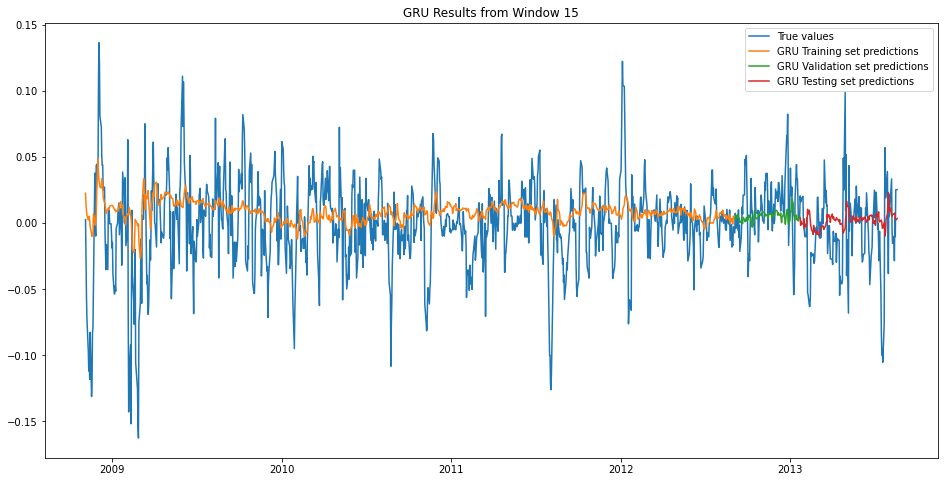

Window 16: 
Training datapoints: 2250 - 3249
Validation datapoints: 3250 - 3349
Testing datapoints: 3350 - 3499

Results on Training set: 
MSE = 0.000668181257021396
RMSE = 0.025849202251160403
MAE = 0.018682143674411688
R-Squared = 0.1953093322980266

Results on Validation set: 
MSE = 0.0010495805075869816
RMSE = 0.03239722993694031
MAE = 0.02329549007610424
R-Squared = 0.03198986266226167

Results on Testing set: 
MSE = 0.001558081479792796
RMSE = 0.03947254083274595
MAE = 0.0290346236859952
R-Squared = 0.10609264408055386



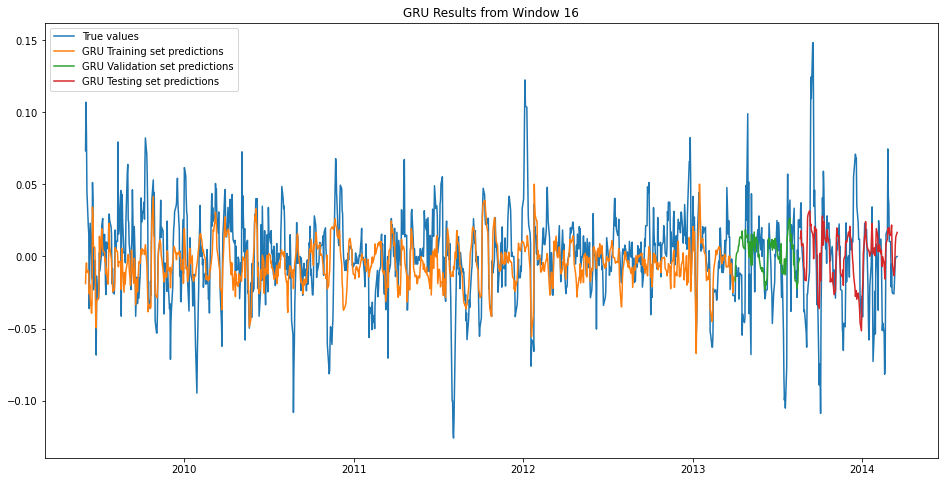

Window 17: 
Training datapoints: 2400 - 3399
Validation datapoints: 3400 - 3499
Testing datapoints: 3500 - 3649

Results on Training set: 
MSE = 0.0007692927793311002
RMSE = 0.02773612769171465
MAE = 0.019405328285041167
R-Squared = 0.17428091409658808

Results on Validation set: 
MSE = 0.0009876672658928386
RMSE = 0.03142717400424096
MAE = 0.023760420049765682
R-Squared = 0.07675506539014565

Results on Testing set: 
MSE = 0.0006737089773991701
RMSE = 0.025955904480467834
MAE = 0.021146613851487646
R-Squared = 0.05570656401302898



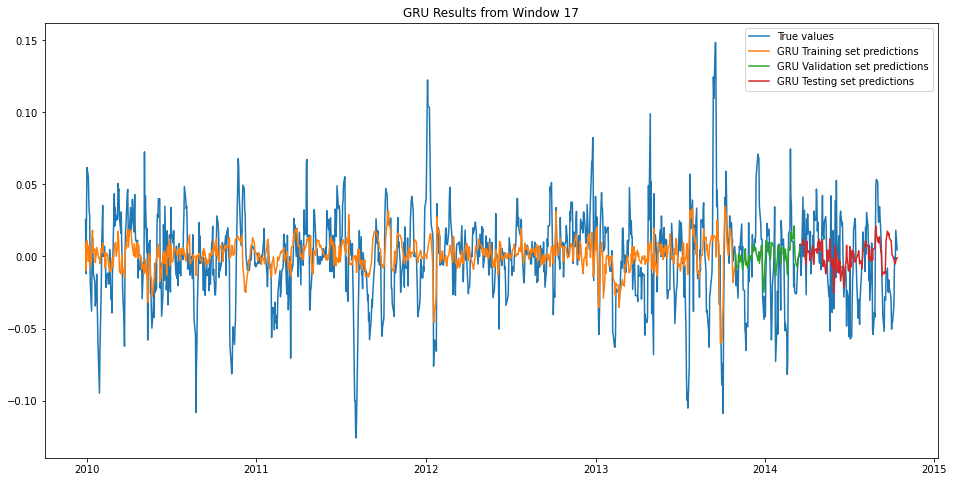

Window 18: 
Training datapoints: 2550 - 3549
Validation datapoints: 3550 - 3649
Testing datapoints: 3650 - 3799

Results on Training set: 
MSE = 0.0006166408812109451
RMSE = 0.024832254855549168
MAE = 0.016891665094001168
R-Squared = 0.3436751470217525

Results on Validation set: 
MSE = 0.000603484591775979
RMSE = 0.024565923385372244
MAE = 0.01996917165060122
R-Squared = 0.1961202348403963

Results on Testing set: 
MSE = 0.0036241033627923583
RMSE = 0.06020052626673922
MAE = 0.04823256358420301
R-Squared = -0.429743590267601



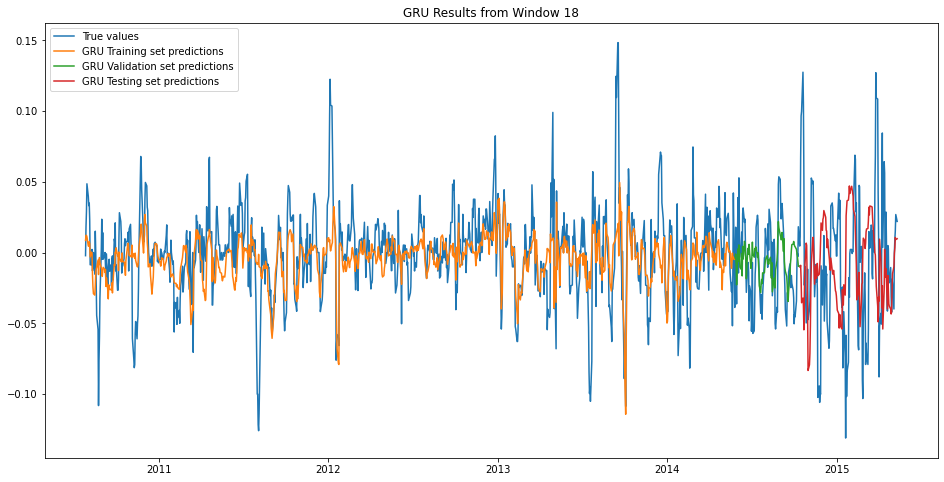

Window 19: 
Training datapoints: 2700 - 3699
Validation datapoints: 3700 - 3799
Testing datapoints: 3800 - 3949

Results on Training set: 
MSE = 0.0010454227390559656
RMSE = 0.03233299768125383
MAE = 0.02353634322846948
R-Squared = -0.0024118679930515974

Results on Validation set: 
MSE = 0.002646868732019174
RMSE = 0.051447728152166
MAE = 0.0392938373000061
R-Squared = -0.12064788276841276

Results on Testing set: 
MSE = 0.001952780788979687
RMSE = 0.044190279349419
MAE = 0.03139966172351147
R-Squared = -0.14253490396194035



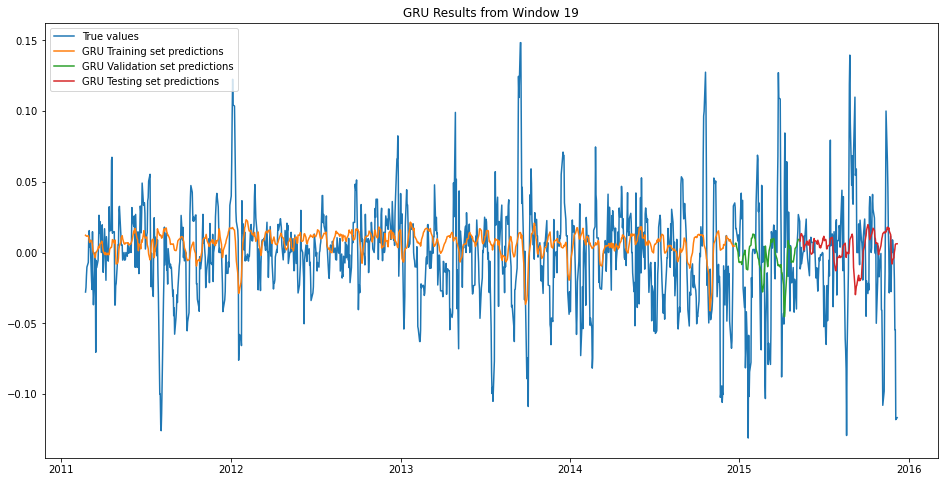

Window 20: 
Training datapoints: 2850 - 3849
Validation datapoints: 3850 - 3949
Testing datapoints: 3950 - 4099

Results on Training set: 
MSE = 0.0010743600941983818
RMSE = 0.032777432696878224
MAE = 0.023282325827524965
R-Squared = 0.07962379908406036

Results on Validation set: 
MSE = 0.0023365744508976366
RMSE = 0.048338126265895294
MAE = 0.03518585657046618
R-Squared = -0.02646146242044556

Results on Testing set: 
MSE = 0.003051563483964896
RMSE = 0.05524095839107877
MAE = 0.04136677385497047
R-Squared = -0.04300890532182544



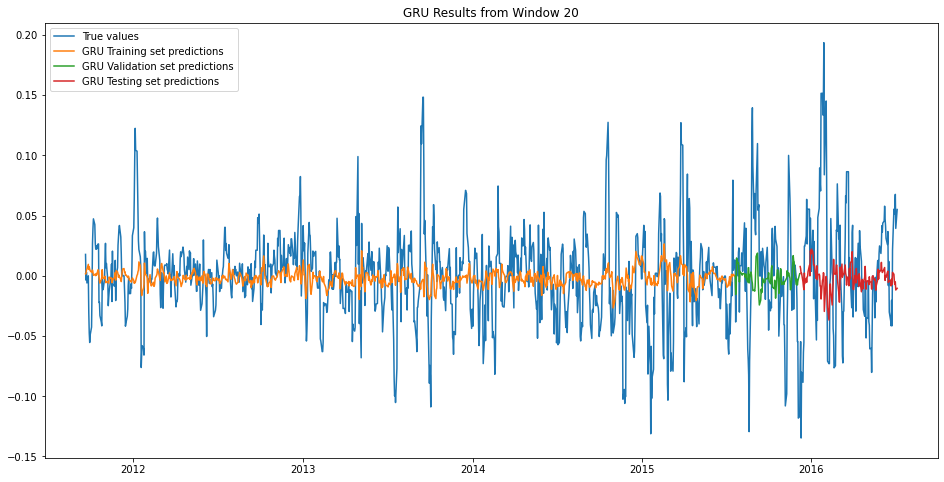

Window 21: 
Training datapoints: 3000 - 3999
Validation datapoints: 4000 - 4099
Testing datapoints: 4100 - 4249

Results on Training set: 
MSE = 0.0005269487821861444
RMSE = 0.022955364997885447
MAE = 0.014930986000633589
R-Squared = 0.6596703825264109

Results on Validation set: 
MSE = 0.001390308853468125
RMSE = 0.03728684558216376
MAE = 0.029388312865000675
R-Squared = 0.10666316923901265

Results on Testing set: 
MSE = 0.0011757143807871186
RMSE = 0.0342886917333852
MAE = 0.026192223212679257
R-Squared = -0.23558135069725905



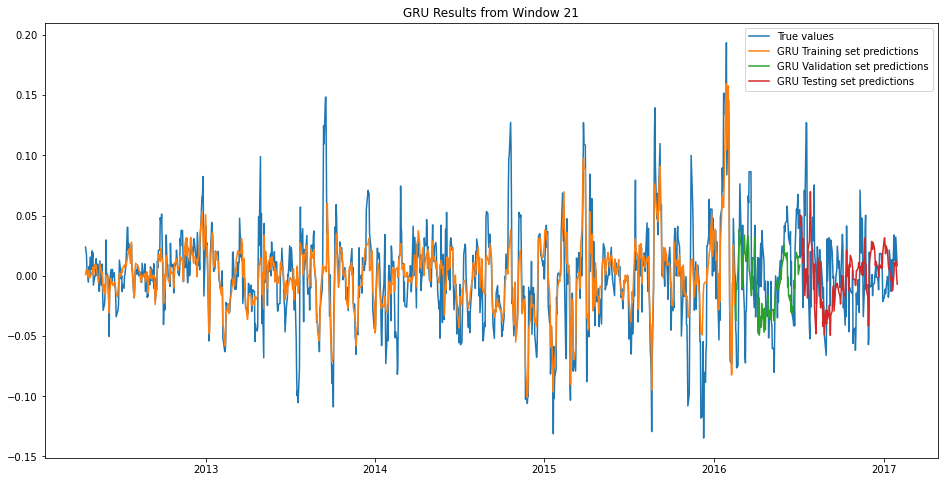

Window 22: 
Training datapoints: 3150 - 4149
Validation datapoints: 4150 - 4249
Testing datapoints: 4250 - 4399

Results on Training set: 
MSE = 0.0016271470238296939
RMSE = 0.04033791050401215
MAE = 0.02873791658319168
R-Squared = 0.06757684874618552

Results on Validation set: 
MSE = 0.0005087462202049863
RMSE = 0.02255540334831072
MAE = 0.016893798558069915
R-Squared = 0.10868697862218879

Results on Testing set: 
MSE = 0.0012031963240086677
RMSE = 0.034687120434084284
MAE = 0.02470114090723913
R-Squared = -0.03846241951640339



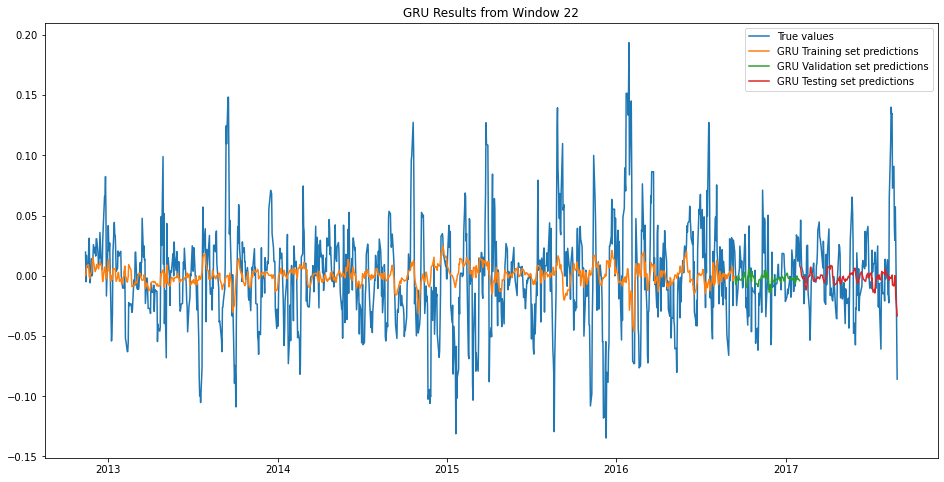

Window 23: 
Training datapoints: 3300 - 4299
Validation datapoints: 4300 - 4399
Testing datapoints: 4400 - 4549

Results on Training set: 
MSE = 0.0006739066616494602
RMSE = 0.025959712279789625
MAE = 0.017787255531800567
R-Squared = 0.6048744342437401

Results on Validation set: 
MSE = 0.0014232640692001676
RMSE = 0.037726172204454664
MAE = 0.02441897759510117
R-Squared = 0.04966855295813677

Results on Testing set: 
MSE = 0.0027417910751352903
RMSE = 0.052362114884096214
MAE = 0.04163334786332087
R-Squared = -0.8252172702237366



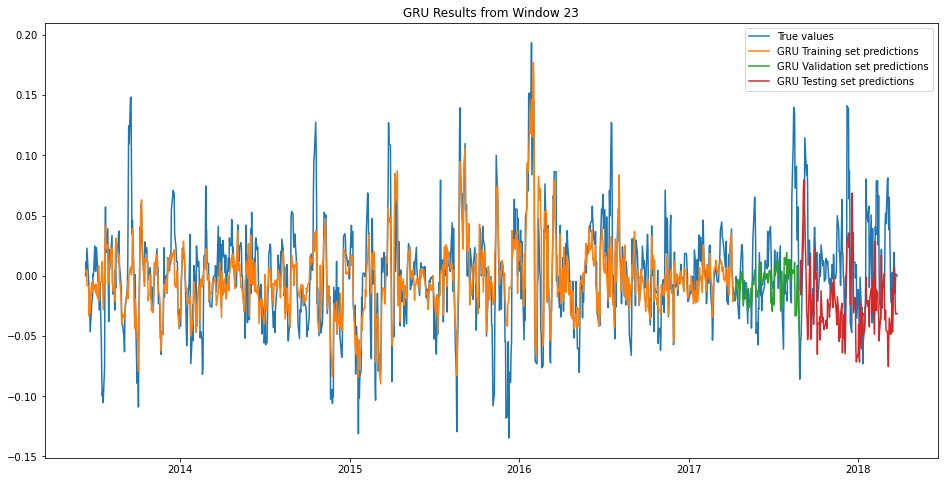

Window 24: 
Training datapoints: 3450 - 4449
Validation datapoints: 4450 - 4549
Testing datapoints: 4550 - 4699

Results on Training set: 
MSE = 0.0009473393671229293
RMSE = 0.030778878587806435
MAE = 0.021872366506600488
R-Squared = 0.4285174733388811

Results on Validation set: 
MSE = 0.0017830193141648242
RMSE = 0.04222581336297531
MAE = 0.03123825622723607
R-Squared = -0.12414165757687678

Results on Testing set: 
MSE = 0.0015558926769248887
RMSE = 0.03944480544919557
MAE = 0.03190031202970583
R-Squared = -0.12257092447211648



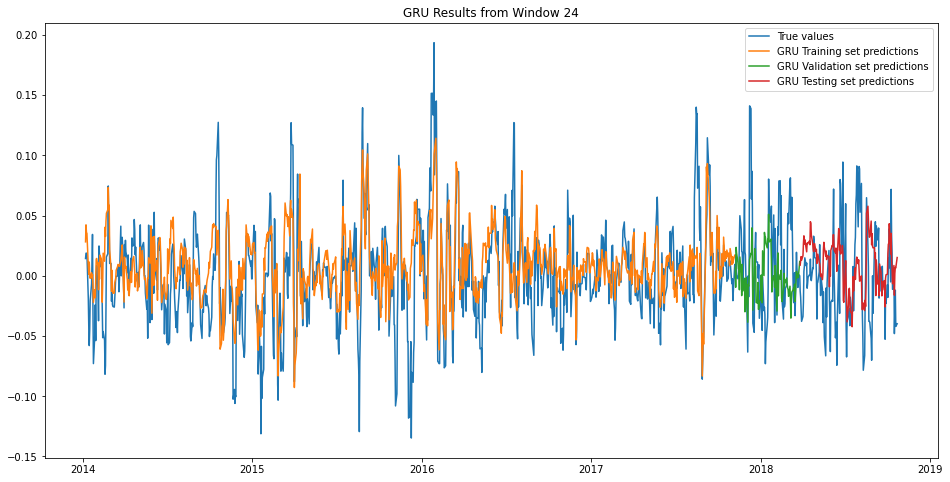

Window 25: 
Training datapoints: 3600 - 4599
Validation datapoints: 4600 - 4699
Testing datapoints: 4700 - 4849

Results on Training set: 
MSE = 0.0015824411183378078
RMSE = 0.03977990847573443
MAE = 0.027984747899967913
R-Squared = 0.08642138729375604

Results on Validation set: 
MSE = 0.001593468961130405
RMSE = 0.03991827853415532
MAE = 0.03169024995878136
R-Squared = 0.11628331412193171

Results on Testing set: 
MSE = 0.0010517184038728363
RMSE = 0.032430208199652935
MAE = 0.025698791414119074
R-Squared = -0.09943929741367641



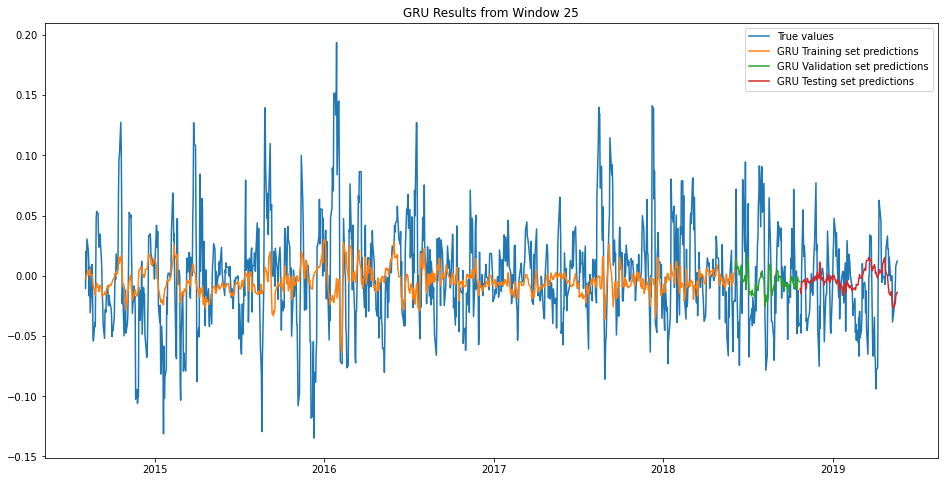

Window 26: 
Training datapoints: 3750 - 4749
Validation datapoints: 4750 - 4849
Testing datapoints: 4850 - 5005

Results on Training set: 
MSE = 0.0014271997421888751
RMSE = 0.03777829723781731
MAE = 0.027007701964655982
R-Squared = 0.12998352887357045

Results on Validation set: 
MSE = 0.0010541497679056675
RMSE = 0.03246767265921085
MAE = 0.025903869189762778
R-Squared = -0.06799863940865647

Results on Testing set: 
MSE = 0.0009782893217326592
RMSE = 0.03127761694459249
MAE = 0.023247975287749377
R-Squared = -0.22579371681999927



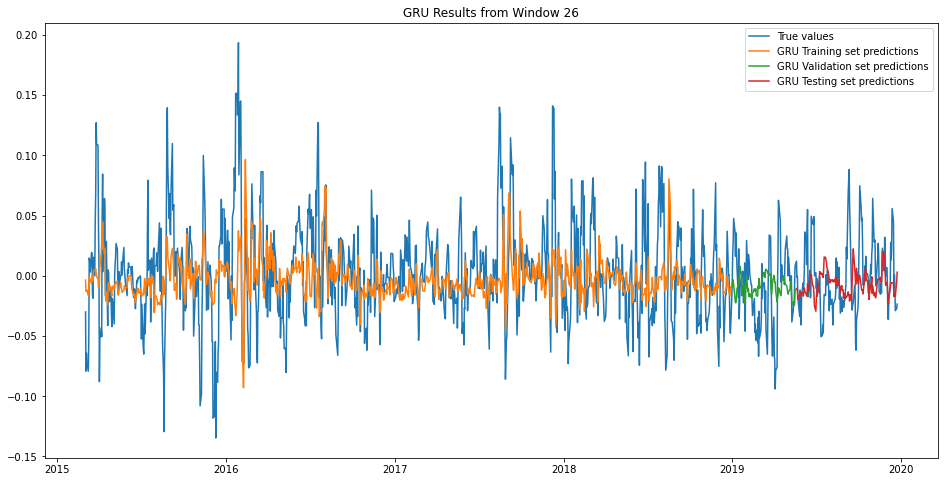

In [10]:
#Declaring model parameters
sequencelength = 113
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength
gru_predictions = np.zeros((numPredictions + extra,1)) 
gru_target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra

  #Print window information
  windowInfo(w, sequencelength, start, trainingSize, validationSize, end)
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #Create, train and test GRU 
  gru_model = create_gru()
  gru_history, gru_model = train_gru(gru_model, x_train, y_train, x_val, y_val)
  gru_predictions, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions = makePredictions(gru_model, gru_predictions, x_train, x_val, x_test)
  evaluate_model(y_trainUnscaled, y_valUnscaled, y_test, gru_trainingPredictions, gru_valPredictions, gru_testingPredictions)

  gru_target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Plot graph of forecasts
  trainGraph = pd.DataFrame(df[start : start + trainingSize])
  trainGraph['GRU Train Predictions'] = gru_trainingPredictions
  valGraph = pd.DataFrame(df[start + trainingSize : end - testingSize])
  valGraph['GRU Val Predictions'] = gru_valPredictions
  testGraph = pd.DataFrame(df[start + trainingSize + validationSize : end])
  testGraph['GRU Test Predictions'] = gru_testingPredictions
  
  #Plot GRU Results
  plt.figure(figsize=(16,8))
  plt.plot(df['Target'][start : end], label='True values')
  plt.plot(trainGraph['GRU Train Predictions'], label = 'GRU Training set predictions')
  plt.plot(valGraph['GRU Val Predictions'], label = 'GRU Validation set predictions')
  plt.plot(testGraph['GRU Test Predictions'], label = 'GRU Testing set predictions')
  plt.title("GRU Results from Window " + str(w + 1))
  plt.legend(loc = 'best')
  plt.show()

  #Update window parameters
  start += testingSize
  end += testingSize

**Naive and Drift Forecasting Implementation**

In [11]:
def naiveForecasts(dataset, begin, horizon, testingSize):
  '''
  Naive forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    testingSize - Size of the test set
  @returns:
    naive - forecasts for the window
  '''
  naive = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  return naive.reshape((naive.shape[0],1))

def driftForecasts(dataset, begin, horizon, testingSize):
  '''
  Drift forecasting model
  @params:
    dataset - data to be used
    begin - Index of the test set
    horizon - Size of the forecasting Horizon
    testingSize - Size of the test set
  @returns:
    drift - forecasts for the window
  '''
  drift = dataset[begin-horizon:begin+testingSize-horizon,0].copy()
  for i in range(2, drift.shape[0] + 1): 
    drift[i - 1] = drift[i - 1] + horizon * ((drift[i - 1] - drift[0]) / (i - 1))
  return drift.reshape((drift.shape[0],1))

#Declaring model parameters
sequencelength = 100
scaler = MinMaxScaler(feature_range=(-1, 1))

#Window Variables
start = 0 + sequencelength
trainingSize = 1000
validationSize = 100
testingSize = 150
end = trainingSize + validationSize + testingSize + sequencelength
numWindows = int((totaldatapoints - sequencelength - trainingSize - validationSize) / testingSize)
numPredictions = numWindows * testingSize
extra = totaldatapoints - numPredictions - trainingSize - validationSize - sequencelength 
naive_predictions = np.zeros((numPredictions + extra,1)) 
drift_predictions = np.zeros((numPredictions + extra,1)) 
target = np.zeros((numPredictions + extra,1)) 

for w in range(numWindows):

  #Add the extra datapoints to the test set for the final window
  if w == (numWindows - 1):
    testingSize += extra
    end += extra
  
  #Get train, validation and test sets
  scaler, x_train, y_train, y_trainUnscaled, x_val, y_val, y_valUnscaled, x_test, y_test = split(dataset, sequencelength, features, scaler, start, trainingSize, validationSize, testingSize, end)

  #naive and drift forecasts
  begin = start + trainingSize + validationSize
  naive_predictions[start - sequencelength: start - sequencelength + testingSize, :] = naiveForecasts(dataset, begin, forecastHorizon, testingSize)
  drift_predictions[start - sequencelength: start - sequencelength + testingSize, :] = driftForecasts(dataset, begin, forecastHorizon, testingSize)
  target[start - sequencelength: start - sequencelength + testingSize, :] = y_test.reshape((y_test.shape[0],1))

  #Update window parameters
  start += testingSize
  end += testingSize

print("Naive and Drift Forecasts completed")

Naive and Drift Forecasts completed


**Overall Results**

In [12]:
def overall(actual, predictions, model):
  '''
  Calculate the overall performance of the model
  @params:
    actual - True Values
    predictions - Predicted Values
    model - Name of the model used
  '''
  mse = mean_squared_error(actual, predictions)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(actual, predictions)
  r2 = r2_score(actual, predictions)

  print(model + " results on the Testing set")
  print('MSE = ' + str(mse))
  print('RMSE = ' + str(rmse))
  print('MAE = ' + str(mae))
  print('R-Squared = ' + str(r2))
  print()

#Performance Metrics
overall(lstm_target, lstm_predictions, "LSTM model")
overall(gru_target, gru_predictions, "GRU model")
overall(target, naive_predictions, "Naive model")
overall(target, drift_predictions, "Drift model")

#For Plots
numpreds = 0
if lstm_predictions.shape[0] <= gru_predictions.shape[0]:
  numpreds = lstm_predictions.shape[0]
else:
  numpreds = gru_predictions.shape[0]

testGraph = pd.DataFrame(df[-numpreds:]['Target'])
testGraph['LSTM'] = lstm_predictions[-numpreds:]
testGraph['GRU'] = gru_predictions[-numpreds:]
testGraph['Naive'] = naive_predictions[-numpreds:]
testGraph['Drift'] = drift_predictions[-numpreds:]

LSTM model results on the Testing set
MSE = 0.0015331289125677164
RMSE = 0.03915519011022314
MAE = 0.02834905892110351
R-Squared = -0.1408759935149344

GRU model results on the Testing set
MSE = 0.0015506010440240207
RMSE = 0.039377671896952224
MAE = 0.028820624790884375
R-Squared = -0.15155533152377476

Naive model results on the Testing set
MSE = 0.002735020544106099
RMSE = 0.05229742387638323
MAE = 0.039048578673208045
R-Squared = -1.0352621719949342

Drift model results on the Testing set
MSE = 0.0033999806803436546
RMSE = 0.058309353283531234
MAE = 0.04290629077894392
R-Squared = -1.5300914390311067



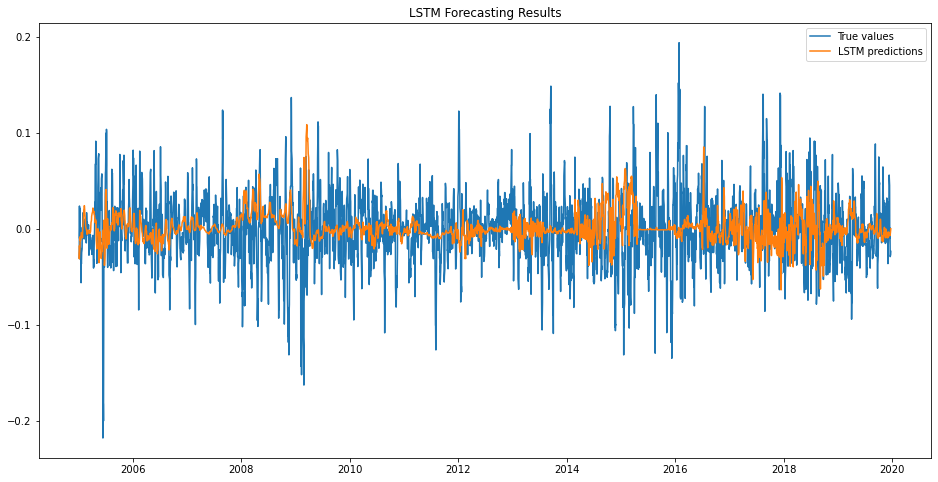

In [13]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['LSTM'], label = 'LSTM predictions')
plt.title("LSTM Forecasting Results")
plt.legend()
plt.show()

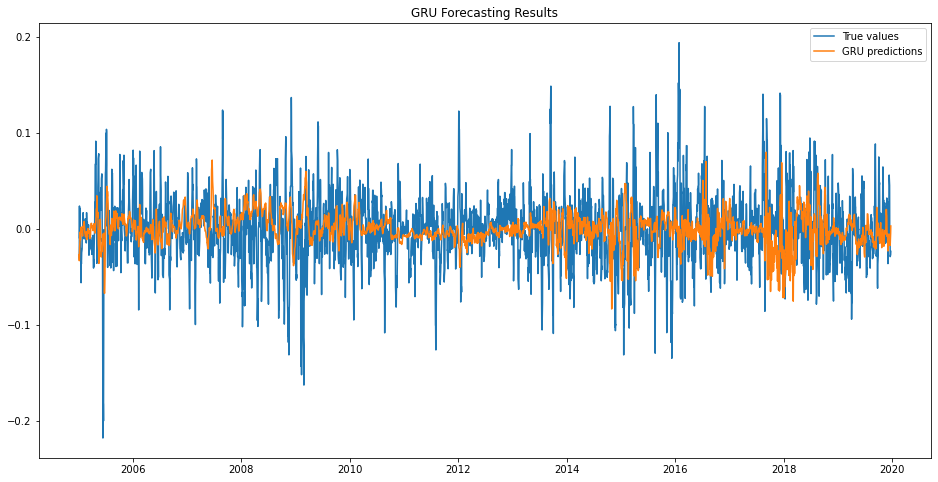

In [14]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['GRU'], label = 'GRU predictions')
plt.title("GRU Forecasting Results")
plt.legend()
plt.show()

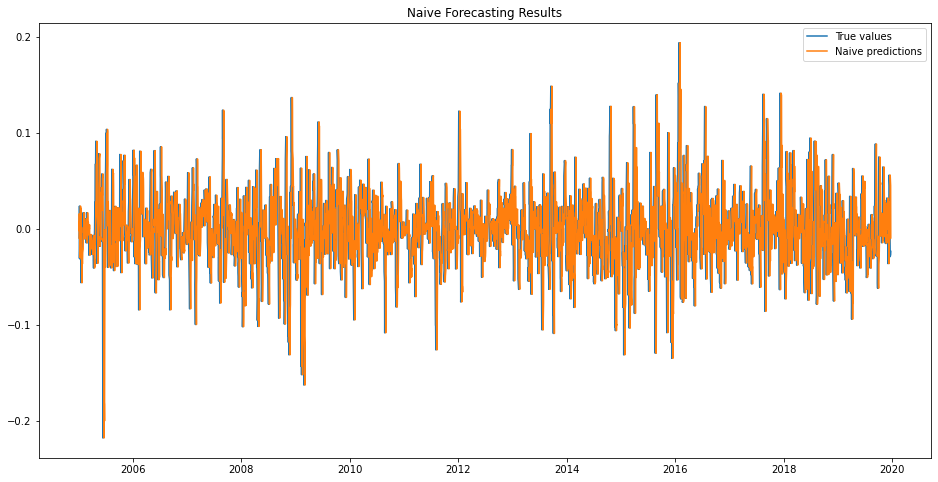

In [15]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Naive'], label = 'Naive predictions')
plt.title("Naive Forecasting Results")
plt.legend()
plt.show()

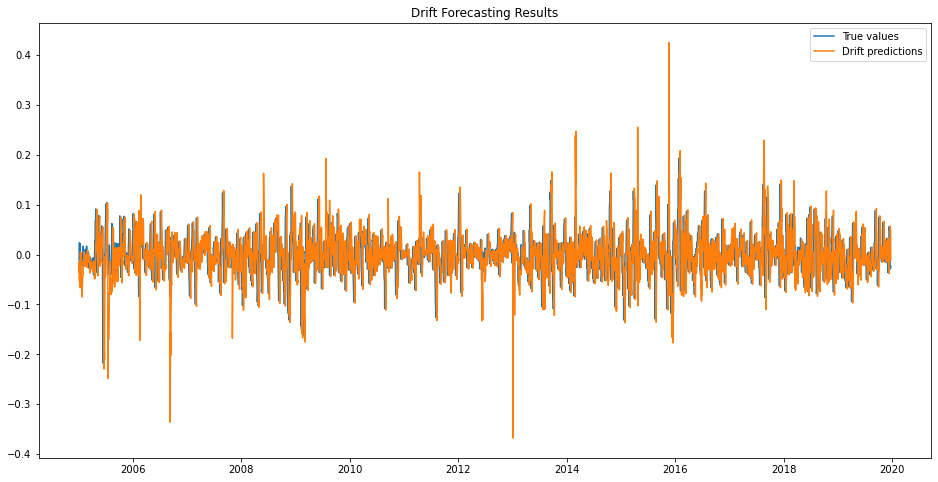

In [16]:
plt.figure(figsize=(16,8))
plt.plot(testGraph['Target'], label='True values')
plt.plot(testGraph['Drift'], label = 'Drift predictions')
plt.title("Drift Forecasting Results")
plt.legend()
plt.show()

**Save the predictions to a csv file**

In [17]:
savePredictions = pd.DataFrame(df[-numpreds:]['Target'])

savePredictions['AFX LSTM'] = lstm_predictions[-numpreds:]
savePredictions['AFX GRU'] = gru_predictions[-numpreds:]
savePredictions['AFX Naive'] = naive_predictions[-numpreds:]
savePredictions['AFX Drift'] = drift_predictions[-numpreds:]
savePredictions.drop(['Target'], axis=1, inplace=True)

savePredictions.to_csv(r'./AFX_Predictions.csv', index=True, header=True)

In [18]:
savePredictions.head()

AFX LSTM   AFX GRU  AFX Naive  AFX Drift
Date                                                
2005-01-04 -0.018080 -0.026896  -0.009852  -0.052508
2005-01-05 -0.031159 -0.033144   0.015717  -0.014759
2005-01-06 -0.027822 -0.022242  -0.002397  -0.036880
2005-01-07 -0.024620 -0.019120   0.007952  -0.021142
2005-01-10 -0.017438 -0.011094  -0.002002  -0.032312